<a href="https://colab.research.google.com/github/JuanParias29/ML_pyspark_IndianWater/blob/main/ML_pyspark_IndianWater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

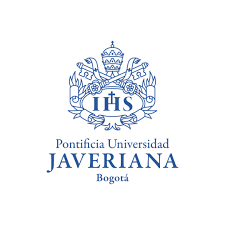

# Procesamiento de Alto Volumen de Datos

🥷 **Autor:** **[Juan Pablo Arias](https://github.com/JuanParias29/Perfil_GitHub)**

📅 **Fecha:** 7 de Enero de 2025  

---

## **Objetivo General**

* Explorar el uso de **MLLIB**, la biblioteca de aprendizaje automático de **PySpark**, para la creación de modelos de predicción relacionados con la calidad del agua. La información sobre la calidad del agua es vital para poder tomar decisiones informadas sobre su uso y tratamiento.

## **Metodología**

1. **Preprocesamiento de Datos**: En esta etapa, se hace una limpieza de los datos, eliminando valores faltantes, corrigiendo errores en los registros y normalizando las variables.

2. **Exploración de Datos**: Se realiza un análisis exploratorio para entender la distribución de los datos, identificar patrones de comportamiento, y detectar relaciones entre las características del agua (pH, temperatura, turbidez, etc.) y su calidad.

3. **Entrenamiento de Modelos Predictivos**: Utilizando la biblioteca **MLLIB** de PySpark, se entrenan modelos de clasificación o regresión, dependiendo de la naturaleza de los datos para predecir la calidad del agua en función de las características observadas.

4. **Evaluación de Modelos**: Se utiliza un conjunto de datos de prueba para evaluar la precisión del modelo. Métricas como la **exactitud**, **R2**, **precisión**, **recall** y **F1-score** se emplean para determinar qué tan bien el modelo está prediciendo los resultados.
---

# Instalación e importacion de Librerias y Paquetes

Este proyecto utiliza varias librerías y paquetes de Python y Spark para realizar un análisis de datos eficiente y visualmente comprensible. A continuación, se describen las principales librerías utilizadas, agrupadas por su función principal.

- 📊 **Librerías para Manipulación de Datos**
  - **pandas**: Utilizada para manipular y analizar datos estructurados en forma de tablas.
  - **numpy**: Empleada para operaciones matemáticas y de álgebra lineal sobre matrices y arrays.

- 📈 **Librerías para Visualización de Datos**
  - **matplotlib**: Usada para crear gráficos estáticos y visualizaciones en 2D.
  - **seaborn**: Extiende `matplotlib` para crear visualizaciones estadísticamente informativas y estilizadas.

- 🌍 **Librerías para Análisis Geoespacial**
  - **geopandas**: Permite la manipulación de datos geoespaciales, como shapefiles y geojson, para análisis espaciales y visualización en mapas.

- 🔥 **Librerías para Análisis en Big Data con Spark**
  - **pyspark**: Utilizada para el procesamiento y análisis de grandes volúmenes de datos distribuidos utilizando Apache Spark.
  
- 🤖 **Librerías para Redes Neuronales y Aprendizaje Automático**
  - **keras**: Framework de alto nivel para construir y entrenar modelos de redes neuronales.
  - **Sequential**: Utilizado para crear modelos secuenciales en Keras.
  - **Dense**: Capa densa en redes neuronales, utilizada en modelos para realizar cálculos en cada unidad.

- 🛠️ **Configuración del Entorno**
  - **SparkContext y SparkSession**: Configuran el entorno de Spark para ejecutar tareas de procesamiento distribuido de datos.

In [ ]:
## Instalación
!pip install pyspark

!pip install mapclassify

In [ ]:
## Importación
import os
os.environ['SHAPE_RESTORE_SHX'] = 'YES'
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import keras
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

from pylab import *
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()
sqlContext = SQLContext(sc)

# Conexión a Drive

In [ ]:
## Se conecta con el drive de google, para tener acceso a la ruta de los archivos
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Cargar el csv con los datos de calidad del agua en la INDIA y el shp con la información geoespacial
rutaCSV = '/content/drive/MyDrive/PROCESAMIENTO_BIG_DATA/Calidad_Agua/waterquality.csv'
rutaIndia = '/content/drive/MyDrive/PROCESAMIENTO_BIG_DATA/Calidad_Agua/Indian_States.shp'

In [ ]:
## Definir el df y gdf usando spark para procesarlo
df00 = spark.read.csv(rutaCSV, header=True, inferSchema=True)
gpdf00 = gpd.read_file(rutaIndia)

In [ ]:
## Se hace inspeccion sobre los datos CSV
df00.show(5)

+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|TOTAL_COLIFORM|
+------------+--------------------+-----------+----+---+---+------------+---+-------------------+--------------+--------------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|         735|3.4|                  2|             3|            73|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|  6|8.0|         270|3.1|                  2|            72|           182|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|         355|4.2|                  9|            59|           133|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|         371|5.6|               3.55|            90|           283|
|        2183|GODAVARI RIVER AT...|MAHARASHTRA|25.7|5.7|7.9|         294|3.2|               2.69|       

# Análisis y Preparación de Datos (EDA)
Se presentan los datos que contienen los parámetros de diferentes rios en la India. Cada dato o parámetro es el promedio de valores medidos sobre un período de tiempo. Los datos han sido extraidos de la web oficial de datos de la India.


- **Tipo de Datos:** Coherencia de tipo de datos, transformación.
- **Columnas:** Conocimiento de columnas, eliminación de necesarias
- **Análisis** de Datos Nulos o Imposibles: Conocimiento cantidad, acción.

## Parámetros de la Calidad del Agua

Se presentan los parámetros y sus definiciones de la calidad del agua en las regiones de la India. La definición de las fuentes, impactos, efectos y métodos de medida de la base de datos no son contempladas en el presente estudio. Las definiciones de los parámetros dados por la base de datos son extraídas de **[2]**.

## Parámetros

- **STATION CODE**: Código de estación
- **LOCATIONS**: Ubicación de estación (Ubicación del Río)
- **STATE**: Estado/Lugar de la India
- **TEMP**: Temperatura promedio del agua (°C)
- **DO**: Oxígeno Disuelto (mg/L). Concentraciones altas de oxígeno disuelto representan mejor calidad del agua.
- **pH**: Se define como el logaritmo negativo de la concentración de hidrógeno. Número adimensional que indica la acidez o base de una solución **[3]**.
- **CONDUCTIVITY**: Mide la habilidad de una solución para conducir corriente eléctrica **[4]**. El agua pura no es buen conductor de electricidad **[5]**.
- **BOD**: Las bacterias y otros microorganismos utilizan sustancias orgánicas como alimento (Demanda Bioquímica de Oxígeno). A medida que metabolizan la materia orgánica, consumen oxígeno **[4]**. Mayor cantidad de material orgánico en el agua, mayor valor de BOD.
- **'NITRATE_N_NITRITE_N'**: Nitrito y Nitrato Nitrogenado. Altas concentraciones de N en la superficie del agua pueden estimular el rápido crecimiento de algas, las cuales degradan la calidad del agua (mg/L) **[4]**.
- **'FECAL_COLIFORM'**: Promedio de bacterias coliformes (excresiones) **[6]**.
- **'TOTAL_COLIFORM'**: Cantidad total de coliformes. Se retira del dataset ya que no aporta información promedio sobre los datos.


## Tipos de Datos
* Se hace un analisis de los parametros que deben contener el dataset y el tipo de dato de cada parametro

In [ ]:
# Muestra los aparametros de calidad de agua del dataset
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM',
 'TOTAL_COLIFORM']

In [ ]:
# Muestra el tipo de dato de cada parametro dentro del dataset
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'string'),
 ('DO', 'string'),
 ('pH', 'double'),
 ('CONDUCTIVITY', 'string'),
 ('BOD', 'string'),
 ('NITRATE_N_NITRITE_N', 'string'),
 ('FECAL_COLIFORM', 'string'),
 ('TOTAL_COLIFORM', 'string')]

## Transformación de Datos

* Se observa que los datos se encuentran en tipo string, lo cual hace difícil el análisis estadístico de los parámetros.
* Se hace una transformación a datos numéricos, específicamente un tipo **Float**, el cual permite realizar cálculos más precisos y aplicar métodos estadísticos adecuados para el análisis de la calidad del agua.

In [ ]:
# Se hace un casting sobre cada columna (parametro) del dataframe y se convierte a flotante
df00 = df00.withColumn('TEMP', df00['TEMP'].cast(FloatType()))
df00 = df00.withColumn('pH', df00['pH'].cast(FloatType()))
df00 = df00.withColumn('DO', df00['DO'].cast(FloatType()))
df00 = df00.withColumn('CONDUCTIVITY', df00['CONDUCTIVITY'].cast(FloatType()))
df00 = df00.withColumn('NITRATE_N_NITRITE_N', df00['NITRATE_N_NITRITE_N'].cast(FloatType()))
df00 = df00.withColumn('FECAL_COLIFORM', df00['FECAL_COLIFORM'].cast(FloatType()))
df00 = df00.withColumn('BOD', df00['BOD'].cast(FloatType()))
df00 = df00.withColumn('TOTAL_COLIFORM', df00['TOTAL_COLIFORM'].cast(FloatType()))
df00.dtypes

[('STATION CODE', 'int'),
 ('LOCATIONS', 'string'),
 ('STATE', 'string'),
 ('TEMP', 'float'),
 ('DO', 'float'),
 ('pH', 'float'),
 ('CONDUCTIVITY', 'float'),
 ('BOD', 'float'),
 ('NITRATE_N_NITRITE_N', 'float'),
 ('FECAL_COLIFORM', 'float'),
 ('TOTAL_COLIFORM', 'float')]

## Eliminación de parámetros irrelevantes

* Se elimina **TOTAL_COLIFORM** porque no aporta al objetivo de la investigación, ya que no proporciona información significativa para el análisis de la calidad del agua en relación con los estados de la India, para ello ya se encuentra con el parametro **FECAL_COLIFORM**


In [ ]:
# Se elimina TOTAL_COLIFORM, no aporta a la investigación
df00 = df00.drop('TOTAL_COLIFORM')
df00.columns

['STATION CODE',
 'LOCATIONS',
 'STATE',
 'TEMP',
 'DO',
 'pH',
 'CONDUCTIVITY',
 'BOD',
 'NITRATE_N_NITRITE_N',
 'FECAL_COLIFORM']

## Limpieza de Datos Nulos o Imposibles

Se requiere limpiar los datos de los valores nulos o imposibles. Para ello, se creará una tabla, ya que ofrece mejor rendimiento para consultas SQL y es adecuada para el procesamiento de alto volumen de datos. Posteriormente, se realizará una consulta SQL para eliminar los datos que no se requieren. A continuación, los pasos:

1. **Se crea la tabla**: Primero se crea una nueva tabla en la base de datos para almacenar los datos limpios, asegurando que se definan correctamente los tipos de datos para cada parámetro.
2. **Se hace la consulta a la Tabla**: A continuación, se realiza una consulta SQL que identificará y eliminará los registros con valores nulos o imposibles según los criterios definidos, garantizando que solo queden los datos relevantes para el análisis.


In [ ]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   5|  2|  0|          30|  6|                  2|            82|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



In [ ]:
df00.createOrReplaceTempView("df00_sql")

In [ ]:
##Se hace la consulta, que retorna el df00 limpio, que se llamará df01
df01 = spark.sql('''Select * from df00_sql where TEMP is not null and
                    DO is not null and
                    pH is not null and
                    CONDUCTIVITY is not null and
                    BOD is not null and
                    NITRATE_N_NITRITE_N is not null and
                    FECAL_COLIFORM is not null''')

* Se verifica la eliminación de Datos Nulos o Imposibles

In [ ]:
df01.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|STATION CODE|LOCATIONS|STATE|TEMP| DO| pH|CONDUCTIVITY|BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+
|           0|        0|    0|   0|  0|  0|           0|  0|                  0|             0|
+------------+---------+-----+----+---+---+------------+---+-------------------+--------------+



* Se presenta información estadística de las columnas

In [ ]:
for col in df01.columns:
  df01.describe([col]).show()

+-------+------------------+
|summary|      STATION CODE|
+-------+------------------+
|  count|               447|
|   mean|2056.6196868008947|
| stddev| 750.6013394156962|
|    min|                11|
|    max|              3330|
+-------+------------------+

+-------+-------------------+
|summary|          LOCATIONS|
+-------+-------------------+
|  count|                447|
|   mean|               NULL|
| stddev|               NULL|
|    min|          AHMEDABAD|
|    max|ZUARI AT PANCHAWADI|
+-------+-------------------+

+-------+--------------+
|summary|         STATE|
+-------+--------------+
|  count|           447|
|   mean|          NULL|
| stddev|          NULL|
|    min|ANDHRA PRADESH|
|    max|   WEST BENGAL|
+-------+--------------+

+-------+-----------------+
|summary|             TEMP|
+-------+-----------------+
|  count|              447|
|   mean|25.49843395369698|
| stddev| 3.31128283673611|
|    min|             10.5|
|    max|             33.8|
+-------+--------

# Visualización de los Datos

* Para cada parámetro de concentración promedio, se hará una consulta SQL desde la tabla temporal, y posteriormente se utilizará un RDD con una *función lambda* para colectar los datos (vector de datos).

* **RDD** (Resilient Distributed Dataset) es una estructura de datos de Apache Spark que permite procesar datos en paralelo. Los RDD son la principal abstracción de datos de Spark y se encuentran en el núcleo del sistema de computación.

In [ ]:
# creación de tablas con datos limpios para visualizar los datos
df01.createOrReplaceTempView("df01_sql")

In [ ]:
# Hacer los vectores de la tabla para cada parámetro
DO_parametro = spark.sql("Select DO from df01_sql")
DO_parametro = DO_parametro.rdd.map(lambda fila: fila.DO).collect()

pH_parametro = spark.sql('''Select pH from df01_sql''')
pH_parametro = pH_parametro.rdd.map(lambda fila: fila.pH).collect()

TEMP_parametro = spark.sql('''Select TEMP from df01_sql''')
TEMP_parametro = TEMP_parametro.rdd.map(lambda fila: fila.TEMP).collect()

CONDUCTIVITY_parametro = spark.sql('''Select CONDUCTIVITY from df01_sql''')
CONDUCTIVITY_parametro = CONDUCTIVITY_parametro.rdd.map(lambda fila: fila.CONDUCTIVITY).collect()

BOD_parametro = spark.sql('''Select BOD from df01_sql''')
BOD_parametro = BOD_parametro.rdd.map(lambda fila: fila.BOD).collect()


NITRATE_N_NITRITE_N_parametro = spark.sql('''Select NITRATE_N_NITRITE_N from df01_sql''')
NITRATE_N_NITRITE_N_parametro = NITRATE_N_NITRITE_N_parametro.rdd.map(lambda fila: fila.NITRATE_N_NITRITE_N).collect()


FECAL_COLIFORM_parametro = spark.sql('''Select FECAL_COLIFORM from df01_sql''')
FECAL_COLIFORM_parametro = FECAL_COLIFORM_parametro.rdd.map(lambda fila: fila.FECAL_COLIFORM).collect()

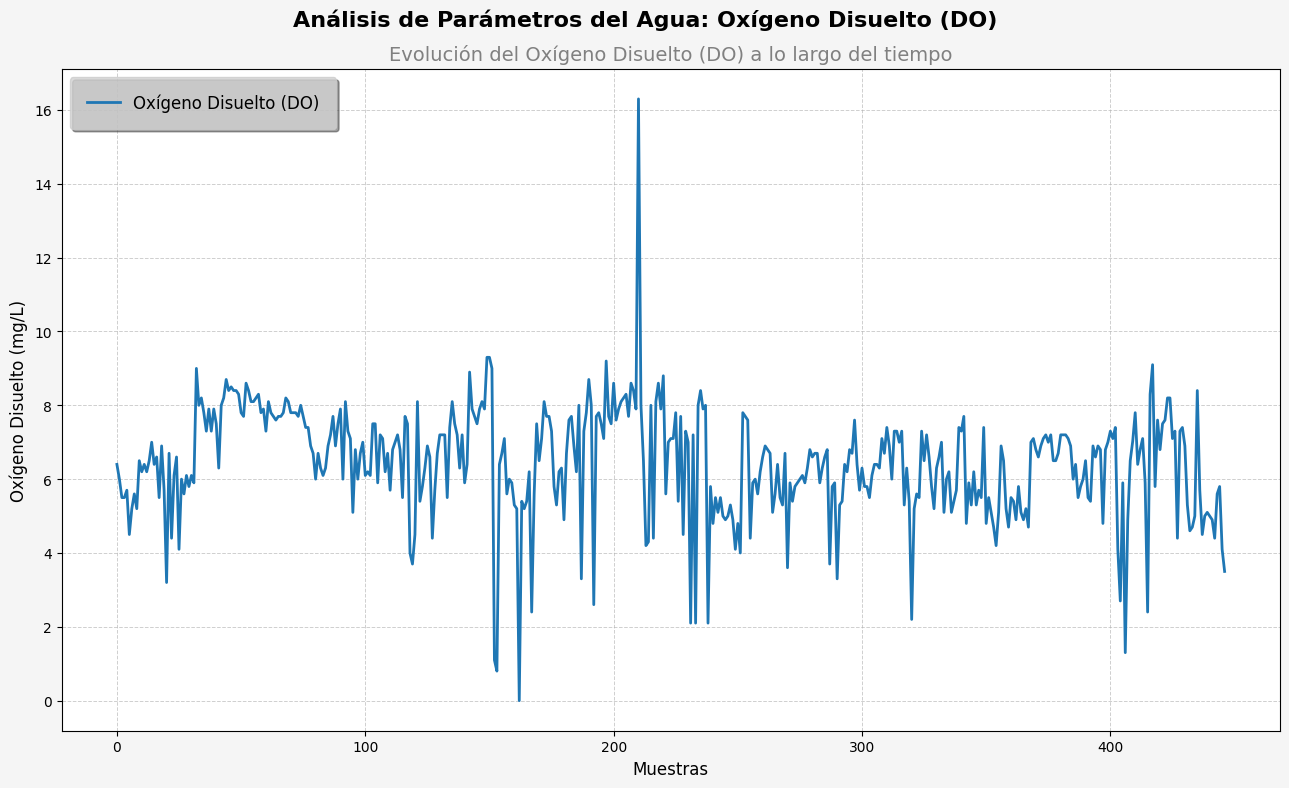

In [ ]:
# Graficar el parámetro DO (Oxígeno Disuelto)
tam = len(DO_parametro)
fig, ax1 = plt.subplots(figsize=(13, 8))
ax1.plot(range(0, tam), DO_parametro, label='Oxígeno Disuelto (DO)', color='tab:blue', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: Oxígeno Disuelto (DO)', fontsize=16, fontweight='bold', color='black')
ax1.set_title('Evolución del Oxígeno Disuelto (DO) a lo largo del tiempo', fontsize=14, color='grey')
ax1.set_xlabel('Muestras', fontsize=12)
ax1.set_ylabel('Oxígeno Disuelto (mg/L)', fontsize=12)

# Leyenda
legend = ax1.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Observaciones del Gráfico de DO

* Se observa una alta variabilidad en los valores de oxígeno disuelto, lo que sugiere fluctuaciones en la calidad del agua. Estas variaciones pueden estar influenciadas por factores como la temperatura, la contaminación o la actividad biológica. Esto según las fuentes consultadas:

  * [Folleto Informativo
Oxígeno Disuelto (OD)](https://www.waterboards.ca.gov/water_issues/programs/swamp/docs/cwt/guidance/3110sp.pdf)
  * [El oxigeno disuelto y su Importancia en la Calidad del Agua](https://myminstrumentostecnicos.com/el-oxigeno-disuelto-y-su-importancia-en-la-calidad-del-agua/)


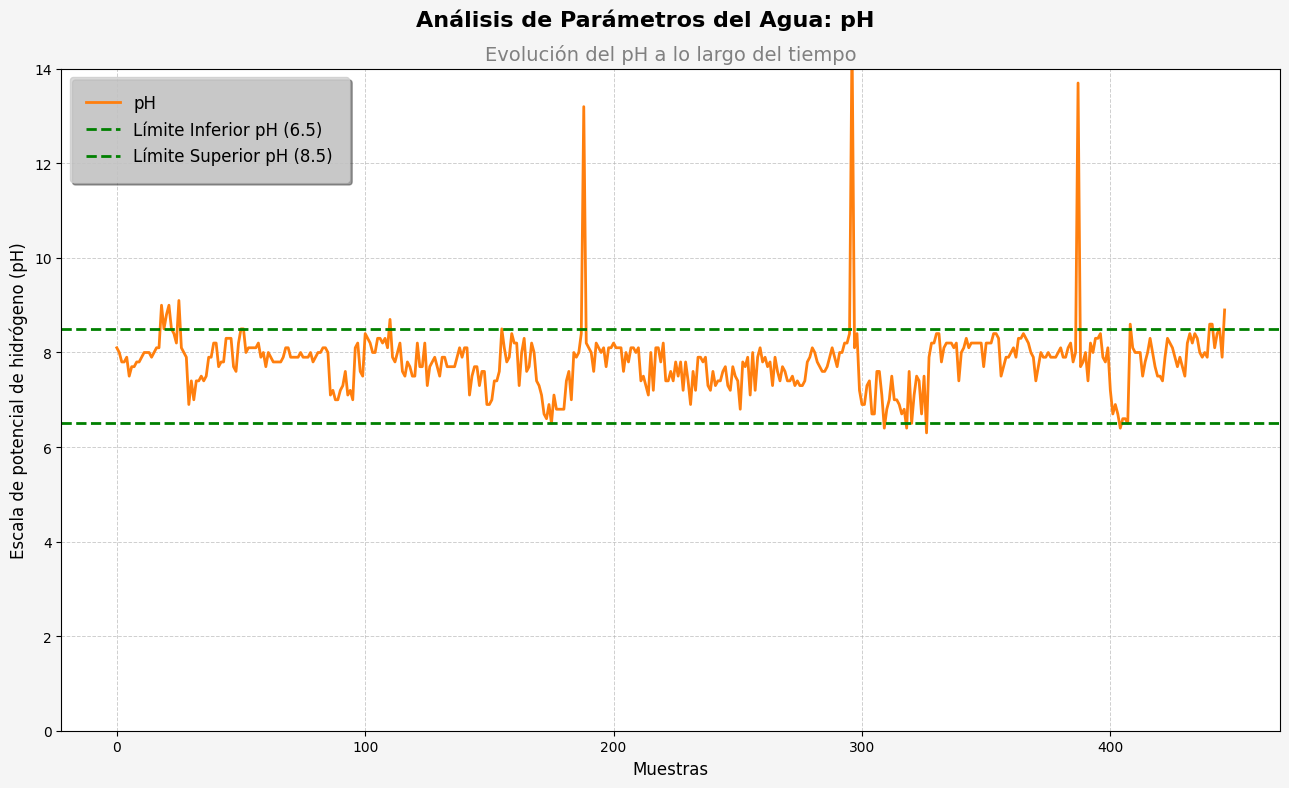

In [ ]:
import matplotlib.pyplot as plt

# Suponiendo que pH_parametro es la lista de los valores del pH
tam = len(pH_parametro)

fig, ax2 = plt.subplots(figsize=(13, 8))

# Graficar el parámetro pH
ax2.plot(range(0, tam), pH_parametro, label='pH', color='tab:orange', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: pH', fontsize=16, fontweight='bold', color='black')
ax2.set_title('Evolución del pH a lo largo del tiempo', fontsize=14, color='grey')
ax2.set_xlabel('Muestras', fontsize=12)
ax2.set_ylabel('Escala de potencial de hidrógeno (pH)', fontsize=12)

# Agregar líneas horizontales que indican el rango de pH adecuado para agua
ax2.axhline(y=6.5, color='green', linestyle='--', label='Límite Inferior pH (6.5)', linewidth=2)
ax2.axhline(y=8.5, color='green', linestyle='--', label='Límite Superior pH (8.5)', linewidth=2)
ax2.set_ylim(0, 14)

# Leyenda
legend = ax2.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')

# Activar la cuadrícula
ax2.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Establecer el fondo del gráfico
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Observaciones del Gráfico de pH

* Aunque el pH presenta algunos picos, en general, se mantiene dentro de un rango adecuado para el agua potable de calidad, que se encuentra entre 6,5 y 8,5. Este rango es respaldado por diversas fuentes consultadas:

  - [El pH del agua potable: ¿cuál debe ser?](https://www.products.pcc.eu/es/blog/cual-debe-ser-el-ph-del-agua-potable/)
  - [¿Qué es el pH del agua?](https://purewater.com.co/que-es-el-ph-del-agua/)
  - [El pH del agua potable: ¿por qué es importante y cuál es el papel de la química?](https://www.colegiodequimicos.org/2023/11/28/el-ph-del-agua-potable-por-que-es-importante-y-cual-es-el-papel-de-la-quimica/)


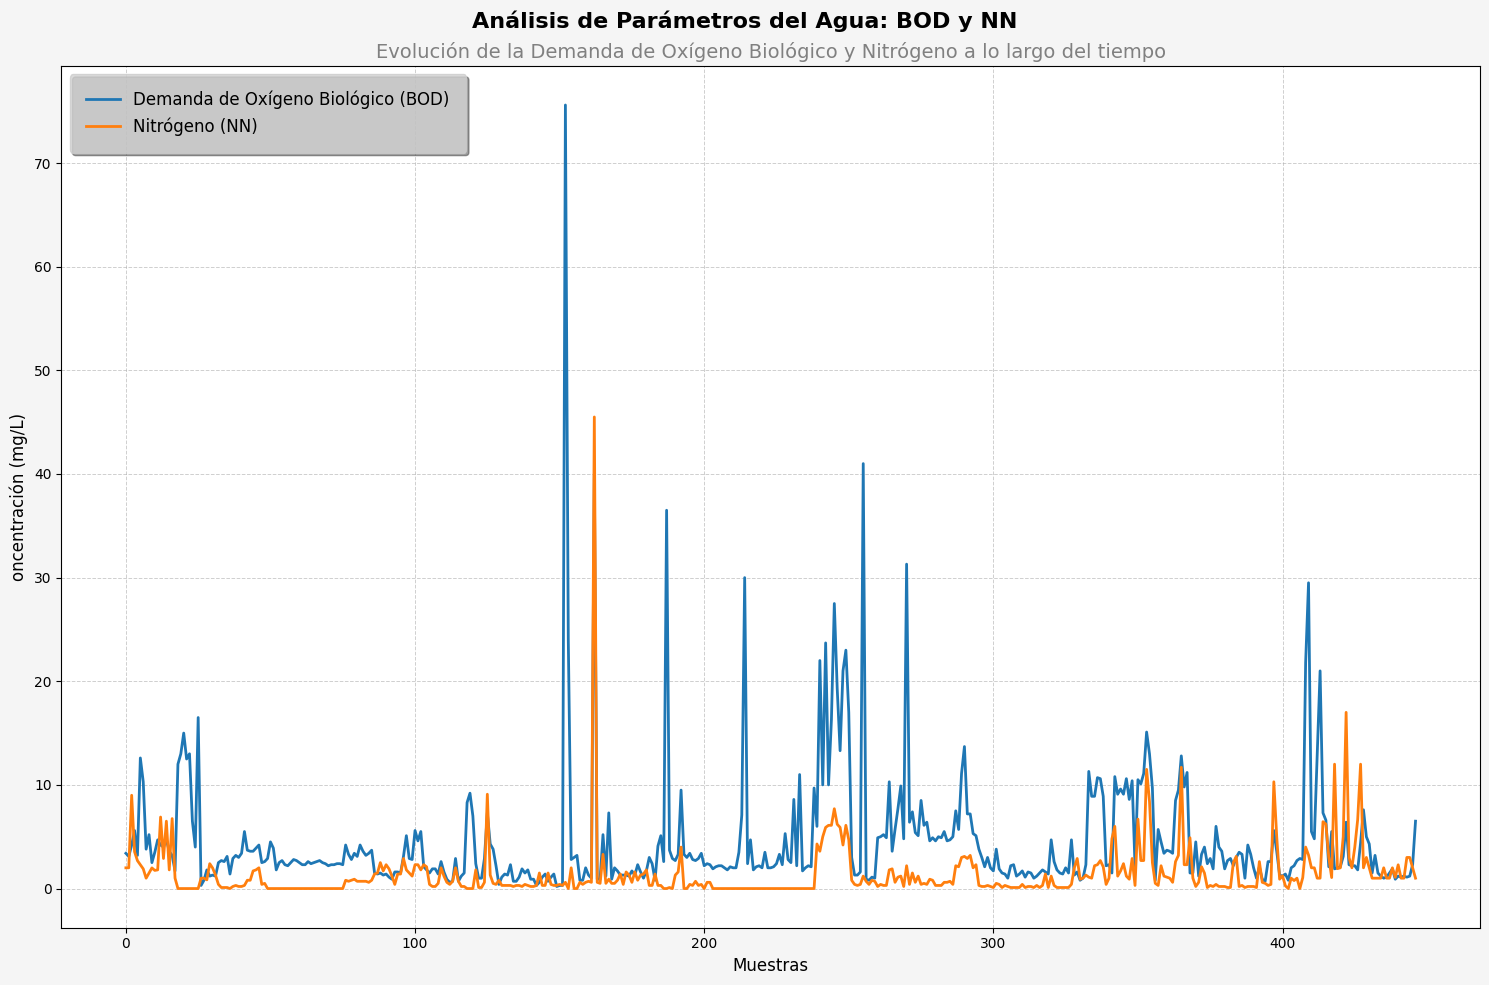

In [ ]:
# Graficos BOD y NITRATE_N_NITRITE_N
tam = len(BOD_parametro)

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 10))

# Graficar los parámetros BOD (Demanda de Oxígeno Biológico) y NN (Nitrógeno)
ax1.plot(range(0, tam), BOD_parametro, label='Demanda de Oxígeno Biológico (BOD)', color='tab:blue', linewidth=2)
ax1.plot(range(0, tam), NITRATE_N_NITRITE_N_parametro, label='Nitrógeno (NN)', color='tab:orange', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros del Agua: BOD y NN', fontsize=16, fontweight='bold', color='black')
ax1.set_title('Evolución de la Demanda de Oxígeno Biológico y Nitrógeno a lo largo del tiempo', fontsize=14, color='grey')
ax1.set_xlabel('Muestras', fontsize=12)
ax1.set_ylabel('oncentración (mg/L)', fontsize=12)

# Agregar una leyenda con fondo y personalización
legend = ax1.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')

# Agregar cuadrícula
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Estilo de fondo
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Observaciones del Gráfico de BOD y NN

* Se evidencia una alta variabilidad en la **Demanda de Oxígeno Biológico** (*BOD*), con picos pronunciados que podrían indicar episodios de alta carga orgánica en el agua, posiblemente debido a contaminación o actividad biológica intensa.

* Los valores de **Nitrógeno** (*NN)* muestran fluctuaciones menores en comparación con el BOD, aunque también se observan picos en ciertos puntos, lo que podría estar relacionado con descargas de compuestos nitrogenados en el agua.

Para comprender mejor las causas de estas variaciones, es recomendable revisar estudios previos y considerar otros parámetros ambientales que puedan influir en la calidad del agua.

Fuentes consultadas:

- [Essential Guide to Biochemical Oxygen Demand (BOD) Measurement & Test](https://www-aquatechtrade-com.translate.goog/news/water-treatment/essential-guide-biochemical-oxygen-demand-measure-test?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc&_x_tr_hist=true)
- [Reducción de la Demanda Biológica de Oxígeno (DBO) en las Aguas Residuales](https://sigmadafclarifiers.com/reduccion-de-la-demanda-biologica-de-oxigeno-dbo-en-las-aguas-residuales/)
- [Parámetros: Nitrógeno](https://es.hach.com/parameters/nitrogen)
- [Nitrogen Management and Water Quality](https://content-ces-ncsu-edu.translate.goog/nitrogen-management-and-water-quality?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc)


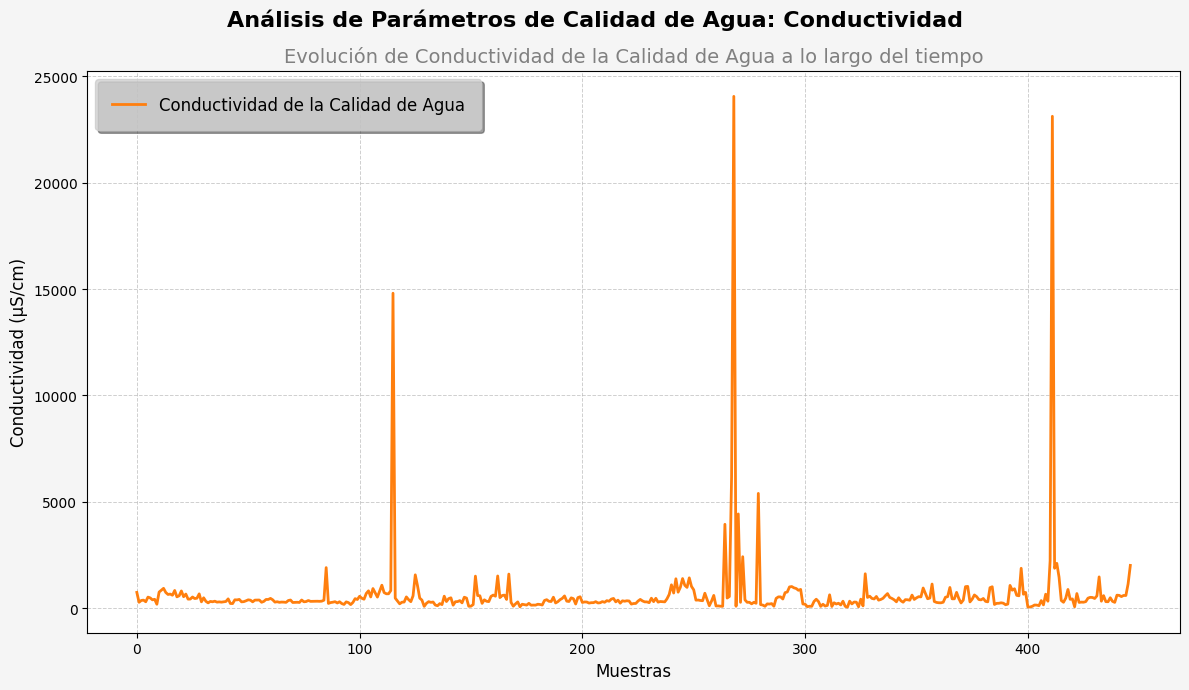

In [ ]:
# Gráfico CONDUCTIVITY
tam = len(BOD_parametro)

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Graficar los parámetros CONDUCTIVITY (Conductividad de la Calidad de Agua)
ax1.plot(range(0, tam), CONDUCTIVITY_parametro, label='Conductividad de la Calidad de Agua', color='tab:orange', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros de Calidad de Agua: Conductividad', fontsize=16, fontweight='bold', color='black')
ax1.set_title('Evolución de Conductividad de la Calidad de Agua a lo largo del tiempo', fontsize=14, color='grey')
ax1.set_xlabel('Muestras', fontsize=12)
ax1.set_ylabel('Conductividad (µS/cm)', fontsize=12)  # Cambié la etiqueta a la unidad de medida de la conductividad

# Agregar una leyenda con fondo y personalización
legend = ax1.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')

# Agregar cuadrícula
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Estilo de fondo
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Observaciones del Gráfico de Conductividad

* Se observa una tendencia general de valores relativamente bajos de conductividad, con algunos valores extremos, superando incluso los **20,000 µS/cm**.

* Estos picos pueden indicar la presencia de sustancias disueltas en el agua en concentraciones anormales, posiblemente debido a descargas de contaminantes, variaciones en la salinidad o cambios en la composición mineral del agua.

La mayor parte de las muestras parecen mantenerse dentro de un rango estable, pero los eventos de alta conductividad requieren una investigación más detallada para determinar sus causas.

### Fuentes consultadas:

- [Rangos de conductividad para diferentes tipos de agua](https://apureinstrument-com.translate.goog/blogs/water-conductivity-range/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc)
- [Conductividad del agua y su relación con diferentes tipos de agua](https://alpha--measure-com.translate.goog/water-conductivity-range/?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc)


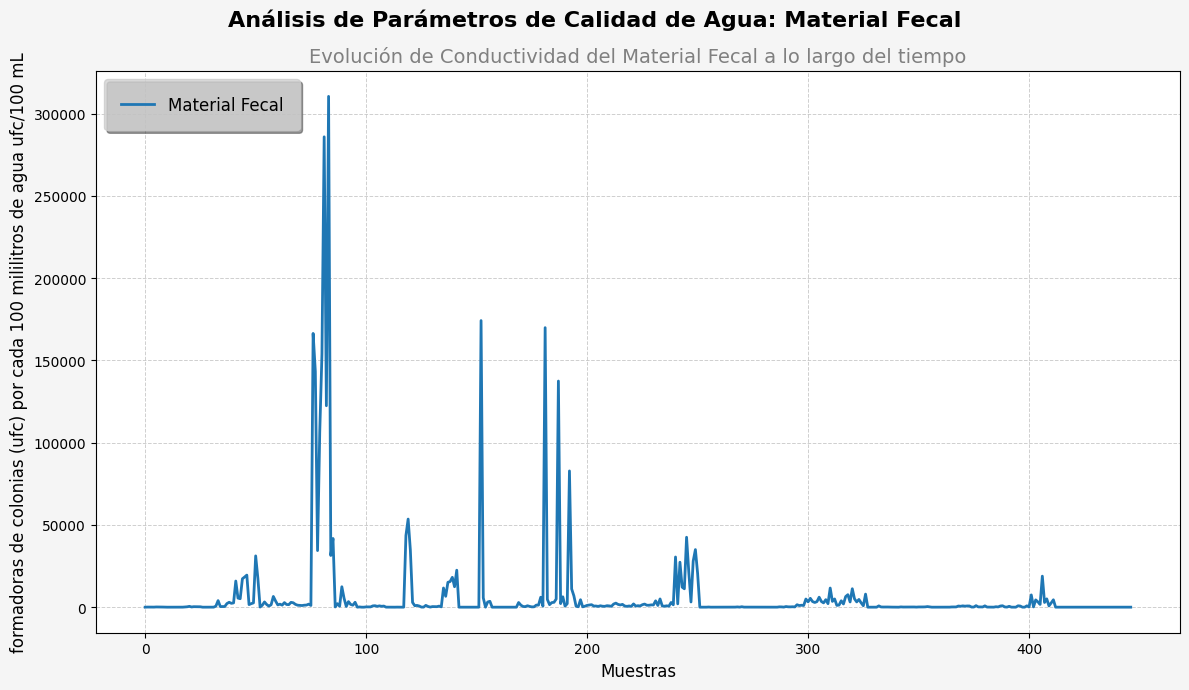

In [ ]:
# Grafico FECAL_COLIFORM
tam = len(BOD_parametro)

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(12, 7))

# Graficar los parámetros CONDUCTIVITY (Conductividad de la Calidad de Agua) y  FECAL_COLIFORM (Material Fecal)
ax1.plot(range(0, tam), FECAL_COLIFORM_parametro, label='Material Fecal', color='tab:blue', linewidth=2)

# Títulos y etiquetas
fig.suptitle('Análisis de Parámetros de Calidad de Agua: Material Fecal', fontsize=16, fontweight='bold', color='black')
ax1.set_title('Evolución de Conductividad del Material Fecal a lo largo del tiempo', fontsize=14, color='grey')
ax1.set_xlabel('Muestras', fontsize=12)
ax1.set_ylabel('formadoras de colonias (ufc) por cada 100 mililitros de agua ufc/100 mL', fontsize=12)

# Agregar una leyenda con fondo y personalización
legend = ax1.legend(loc='upper left', fontsize=12, frameon=True, framealpha=0.8, shadow=True, borderpad=1)
legend.get_frame().set_facecolor('lightgray')

# Agregar cuadrícula
ax1.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)

# Estilo de fondo
fig.patch.set_facecolor('whitesmoke')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## Observaciones del Gráfico de Materia Fecal

* Si bien la mayoría de las muestras parecen presentar valores bajos de Materia Fecal, existen picos muy altos, llegando hasta **300,000 formadoras de colonias por cada 100 Ml de agua**.

* Estos picos elevados pueden indicar contaminación fecal en el agua, lo que podría estar asociado con la presencia de bacterias coliformes. Esta contaminación puede ser un riesgo para la salud, ya que puede llevar a enfermedades graves como diarrea, cólera y otras infecciones gastrointestinales.

### Fuentes consultadas:

- [Coliform Bacteria in Drinking Water](https://www-health-ny-gov.translate.goog/environmental/water/drinking/coliform_bacteria.htm?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc)
- [Contaminación fecal del agua: innovaciones y retos para detectarla](https://higieneambiental.com/aire-agua-y-legionella/contaminacion-fecal-del-agua-innovaciones-y-retos-para-detectarla)
---

# **Ingeniería de Características**


* **Water Quality Index:** El Índice de la Calidad del Agua se calcula agregando linealmente el índice de calidad con la masa.

* WQI = sum(**qr**n * **W**n)

* **qr**n: Rango de Calidad para el n parámetro de calidad de agua.

* **W**n: Unidad de peso para el n parámetro.

A continuación se calcula un método estándar **[2]** para calcular el rango de calidad **qr** para cada parámetro.

* Rango de calidad para **pH**. Se crea una nueva columna con los rangos **pH** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **pH = [7.0 ; 8.5)**
    + 80:  *agua moderada*     **pH = [6.8 ; 6.9) o (8.5 ; 8.6)**
    + 60:  *agua dura* **pH = [6.7 ; 6.8) o [8.6 ; 8.8)**
    + 40:  *agua muy dura* **pH = [6.5 ; 6.7) o [8.8 ; 9.0)**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según el pH

# Crea una nueva columna para los rangos del paramtro
df02 = df01.withColumn('qrPH', F.when((df01.pH>=7) & (df01.pH<8.5), 100).when
 ((df01.pH>=6.8) & (df01.pH<6.9) | (df01.pH>8.5) & (df01.pH<8.6), 80).when
  ((df01.pH>=6.7) & (df01.pH<6.8) | (df01.pH>=8.6) & (df01.pH<8.8), 60).when
   ((df01.pH>=6.5) & (df01.pH<6.7) | (df01.pH>=8.8) & (df01.pH<9.0), 40).otherwise(0))

* Rango de calidad para **Oxigeno Disuelto**. Se crea una nueva columna con los rangos DO de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **DO>=6.0**
    + 80:  *agua moderada* **DO = [5.1, 6.0)**
    + 60:  *agua dura* **DO = [4.1, 5.0]**
    + 40:  *agua muy dura* **DO = [3.0, 4.0]**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según DO

# Crea una nueva columna para los rangos del paramtro
df02 = df02.withColumn('qrDO', F.when((df01.DO) >= 6.0, 100).when
 ((df01.DO>=5.1) & (df01.DO<6.0), 80).when
  ((df01.DO>=4.1) & (df01.DO<=5.0), 60).when
   ((df01.DO>=3.0) & (df01.DO<=4.0), 40).otherwise(0))

* Rango de calidad para **Conductividad**. Se crea una nueva columna con los rangos CONDUCTIVITY de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **CONDUCTIVITY = [0.0,75.0]**
    + 80:  *agua moderada* **CONDUCTIVITY = (75.0, 150.0]**
    + 60:  *agua dura* **CONDUCTIVITY = (150.0, 225.0]**
    + 40:  *agua muy dura* **CONDUCTIVITY = (225.0, 300.0]**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según el CONDUCTIVITY

# Crea una nueva columna para los rangos del paramtro
df02 = df02.withColumn('qrCOND', F.when((df01.CONDUCTIVITY>=0.0) & (df01.CONDUCTIVITY<=75.0), 100).when
 ((df01.CONDUCTIVITY> 75.0 ) & (df01.CONDUCTIVITY<=150.0), 80).when
  ((df01.CONDUCTIVITY>150.0) & (df01.CONDUCTIVITY<=225.0), 60).when
    ((df01.CONDUCTIVITY>225.0) & (df01.CONDUCTIVITY<=300.0), 40).otherwise(0))

* Rango de calidad para **Demanda Bioquímica de Oxigeno**. Se crea una nueva columna con los rangos **BOD** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **BOD = [0.0,3.0]**
    + 80:  *agua moderada* **BOD = (3.0, 6.0]**
    + 60:  *agua dura* **BOD = (6.0, 80.0]**
    + 40:  *agua muy dura* **BOD = (80.0, 125.0]**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según el BOD

# Crea una nueva columna para los rangos del paramtro
df02 = df02.withColumn('qrBOD', F.when((df01.BOD>=0.0) & (df01.BOD<=3.0), 100).when
 ((df01.BOD>3.0) & (df01.BOD<=6.0), 80).when
  ((df01.BOD>6.0) & (df01.BOD<=80.0), 60).when
    ((df01.BOD>80.0) & (df01.BOD<=125.0), 40).otherwise(0))

* Rango de calidad para **Nitratos**. Se crea una nueva columna con los rangos **NITRATE_N_NITRITE_N** de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **NITRATE_N_NITRITE_N = [0.0,20.0]**
    + 80:  *agua moderada* **NITRATE_N_NITRITE_N =  (20.0, 50.0]**
    + 60:  *agua dura* **NITRATE_N_NITRITE_N = (50.0, 100.0]**
    + 40:  *agua muy dura* **NITRATE_N_NITRITE_N = (100.0, 200.0]**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según el NNN

# Crea una nueva columna para los rangos del paramtro
df02 = df02.withColumn('qrNNN', F.when((df01.NITRATE_N_NITRITE_N>=0.0) & (df01.NITRATE_N_NITRITE_N<=20.0), 100).when
 ((df01.NITRATE_N_NITRITE_N>20.0) & (df01.NITRATE_N_NITRITE_N<=50.0), 80).when
  ((df01.NITRATE_N_NITRITE_N>50.0) & (df01.NITRATE_N_NITRITE_N<=100.0), 60).when
    ((df01.NITRATE_N_NITRITE_N>100.0) & (df01.NITRATE_N_NITRITE_N<=200.0), 40).otherwise(0))

* Rango de calidad para **Coliforme Fecal**. Se crea una nueva columna con los rangos FECAL_COLIFORM de la calidad del agua **[2]**. A saber:

    + 100: *agua dulce* **FECAL_COLIFORM = [0.0,5.0]**
    + 80:  *agua moderada* **FECAL_COLIFORM = (5.0, 50.0]**
    + 60:  *agua dura* **FECAL_COLIFORM = (50.0, 500.0]**
    + 40:  *agua muy dura* **FECAL_COLIFORM = (500.0, 10000.0)**
    + 0:   rango agua residuales
    ---

In [ ]:
# Función definida por el usuario para definir el rango de calidad de agua según el FECAL_COLIFORM

# Crea una nueva columna para los rangos del paramtro
df02 = df02.withColumn('qrFC', F.when((df01.FECAL_COLIFORM>=0.0) & (df01.FECAL_COLIFORM<=5.0), 100).when
 ((df01.FECAL_COLIFORM>5.0) & (df01.FECAL_COLIFORM<=50.0), 80).when
  ((df01.FECAL_COLIFORM>50.0) & (df01.FECAL_COLIFORM<=500.0), 60).when
    ((df01.FECAL_COLIFORM>500.0) & (df01.FECAL_COLIFORM<10000.0), 40).otherwise(0))

In [ ]:
# Inspeccion visual del dataframe spark
df02.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNNN|qrFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|  100| 100|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|  100|  60|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|          59.0| 100|  80|     0|   80|  100|  60|
|        2179|GODAVARI RIVER AT...|MAHARASHTRA|24.8|5.5|7.8|       371.0| 5.6|               3.55|          90.0

A continuación se cálcula el WQI para cada parámetro.

La masa del agua puede ser calculado por el producto de su volumen por su densidad. La densidad del agua es aproximadamente 1 gramo por centimetro cúbico (g/cm^3)

In [ ]:
# Se calcula el WQI de cada parametro
from pyspark.sql.functions import round

df03 = df02.withColumn('wPH', round(df02.qrPH * 0.165, 3))
df03 = df03.withColumn('wDO', round(df03.qrDO * 0.165, 3))
df03 = df03.withColumn('wCOND', round(df03.qrCOND * 0.165, 3))
df03 = df03.withColumn('wBOD', round(df03.qrBOD * 0.165, 3))
df03 = df03.withColumn('wNNN', round(df03.qrNNN * 0.165, 3))
df03 = df03.withColumn('wFC', round(df03.qrFC * 0.165, 3))

# se muestra la nueva tabla creada con el WQI de cada parametro
df03.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNNN|qrFC| wPH| wDO|wCOND|wBOD|wNNN| wFC|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|  100| 100|16.5|16.5|  0.0|13.2|16.5|16.5|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|  100|  60|16.5|16.5|  6.6|13.2|16.5| 9.9|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|                9.0|       

Finalmente se calcula el **Índice de Calidad del Agua**

In [ ]:
# Se crea la columna WQI (TENER EN CUENTA QUE LA CANTIDAD DE ATRIBUTOS O PARAMETROS ES INSUFICIENTE PARA UN ESTUDIO SERIE DE CALIDAD DEL AGUA)
df04 = df03.withColumn('WQI', round(df03.wPH + df03.wDO + df03.wCOND + df03.wBOD + df03.wNNN + df03.wFC))

# se muestra la nueva tabla creada con el WQI total
df04.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNNN|qrFC| wPH| wDO|wCOND|wBOD|wNNN| wFC| WQI|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|  100| 100|16.5|16.5|  0.0|13.2|16.5|16.5|79.0|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|  100|  60|16.5|16.5|  6.6|13.2|16.5| 9.9|79.0|
|        2182|GODAVARI RIVER AT...|MAHARASHTRA|25.8|5.5|7.8|       355.0| 4.2|  

## A continuación se clasifica el agua sobre la base de su índice de calidad **[2]**

* Clasificación de calidad del agua:

    + Excelente: *agua dulce* **WQI = [0.0,25.0]**
    + Buena:  *agua moderada* **WQI = (56.0, 50.0]**
    + Baja:  *agua dura* **WQI = (50.0, 75.0]**
    + Muy_Baja:  *agua muy dura* **WQI =(75.0, 100.0]**
    + Inadecuada:   rango agua residuales
    ---

In [ ]:
# Clasificacion de la calidad del agua según la bibliografia
df05 = df04.withColumn('CALIDAD', F.when((df04.WQI>=0.0) & (df04.WQI<=25.0), 'Excelente').when
 ((df04.WQI>25.0) & (df04.WQI<=0.50), 'Buena').when
  ((df04.WQI>50.0) & (df04.WQI<=75.0), 'Baja').when
    ((df04.WQI>75.0) & (df04.WQI<=100.), 'Muy_Baja').otherwise('Inadecuada'))

# se muestra la nueva tabla creada con el WQI total
df05.show(10)

+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+--------+
|STATION CODE|           LOCATIONS|      STATE|TEMP| DO| pH|CONDUCTIVITY| BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNNN|qrFC| wPH| wDO|wCOND|wBOD|wNNN| wFC| WQI| CALIDAD|
+------------+--------------------+-----------+----+---+---+------------+----+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+--------+
|        1312|GODAVARI AT JAYAK...|MAHARASHTRA|29.2|6.4|8.1|       735.0| 3.4|                2.0|           3.0| 100| 100|     0|   80|  100| 100|16.5|16.5|  0.0|13.2|16.5|16.5|79.0|Muy_Baja|
|        2177|GODAVARI RIVER NE...|MAHARASHTRA|24.5|6.0|8.0|       270.0| 3.1|                2.0|          72.0| 100| 100|    40|   80|  100|  60|16.5|16.5|  6.6|13.2|16.5| 9.9|79.0|Muy_Baja|
|        2182|GODAVARI RIVER AT...|

## Visualización de los datos por Estados de la INDIA

* Se visualizan los datos obtenidos de CALIDAD en cada región/estado de la INDIA

In [ ]:
#Primero se obtienen los nombres de regiones sobre el Dataframe de Calidad
df05.select('STATE').distinct().collect()

[Row(STATE='WEST BENGAL'),
 Row(STATE='GOA'),
 Row(STATE='RAJASTHAN'),
 Row(STATE='HIMACHAL PRADESH'),
 Row(STATE='GUJARAT'),
 Row(STATE='BIHAR'),
 Row(STATE='KARNATAKA'),
 Row(STATE='UTTAR PRADESH'),
 Row(STATE='MADHYA PRADESH'),
 Row(STATE='MAHARASHTRA'),
 Row(STATE='PUNJAB'),
 Row(STATE='TAMILNADU'),
 Row(STATE='ANDHRA PRADESH'),
 Row(STATE='KERALA'),
 Row(STATE='ASSAM')]

* Se observan los nombres en el GPD, para hacer que sean similares frente a los del dataframe

In [ ]:
#Se visualiza el dataframe geográfico gpd
type(gpdf00)

geopandas.geodataframe.GeoDataFrame

In [ ]:
gpdf00.columns

Index(['st_nm', 'geometry'], dtype='object')

In [ ]:
#Nombres de los estados en GeoPandas
gpdf00['st_nm'].unique()

array(['Andaman & Nicobar Island', 'Arunanchal Pradesh', 'Assam', 'Bihar',
       'Chandigarh', 'Chhattisgarh', 'Dadara & Nagar Havelli',
       'Daman & Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'NCT of Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

In [ ]:
#Se ajustan los nombres de GPD, eliminando caracteres y extensiones de nombres
gpdf01 = gpdf00.replace({'Andaman & Nicobar Island': 'Andaman and Nicobar Island',
                                   'Dadara & Nagar Havelli': 'Dadara and Nagar Havelli',
                                   'Daman & Diu': 'Daman an Diu',
                                   'Jammu & Kashmir': 'Jammu and Kashmir',
                                   'NCT of Delhi': 'Delhi'})
gpdf01['st_nm'].unique()

array(['Andaman and Nicobar Island', 'Arunanchal Pradesh', 'Assam',
       'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadara and Nagar Havelli',
       'Daman an Diu', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala',
       'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
       'Meghalaya', 'Mizoram', 'Nagaland', 'Delhi', 'Puducherry',
       'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
       'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Odisha',
       'Andhra Pradesh'], dtype=object)

Se hacen cambios sobre el dataframe spark para coincidir nombres

* Para efectos de pintar el mapa se pasa el spark dataframe a pandas
* El nombre de TAMILNADU se cambia por TAMIL NADU
* Se deja sólo la letra inicial mayúsula sobre Dataframe
---

In [ ]:
#Se cambia a objeto pandas
pandasDF = df05.toPandas()

#Cambio TAMILNADU a TAMIL NADU
pandasDF.replace({'TAMILNADU': 'TAMIL NADU'}, inplace = True)

#Se deja letra inicial mayúscula en columna 'STATE'
pandasDF['STATE'] = pandasDF['STATE'].str.title()

#Se comprueba el cambio
display(pandasDF.head(10))

,STATION CODE,LOCATIONS,STATE,TEMP,DO,pH,CONDUCTIVITY,BOD,NITRATE_N_NITRITE_N,FECAL_COLIFORM,...,qrNNN,qrFC,wPH,wDO,wCOND,wBOD,wNNN,wFC,WQI,CALIDAD
0,1312,"GODAVARI AT JAYAKWADI DAM, AURNAGABAD,MAHARASHTRA",Maharashtra,29.200001,6.4,8.1,735.0,3.4,2.00,3.0,...,100,100,16.5,16.5,0.0,13.2,16.5,16.5,79.0,Muy_Baja
1,2177,GODAVARI RIVER NEAR SOMESHWAR TEMPLE.,Maharashtra,24.500000,6.0,8.0,270.0,3.1,2.00,72.0,...,100,60,16.5,16.5,6.6,13.2,16.5,9.9,79.0,Muy_Baja
2,2182,GODAVARI RIVER AT SAIKHEDA.,Maharashtra,25.799999,5.5,7.8,355.0,4.2,9.00,59.0,...,100,60,16.5,13.2,0.0,13.2,16.5,9.9,69.0,Baja
3,2179,"GODAVARI RIVER AT HANUMAN GHAT, NASHIK CITY.",Maharashtra,24.799999,5.5,7.8,371.0,5.6,3.55,90.0,...,100,60,16.5,13.2,0.0,13.2,16.5,9.9,69.0,Baja
4,2183,GODAVARI RIVER AT NANDUR- MADMESHWAR DAM.,Maharashtra,25.700001,5.7,7.9,294.0,3.2,2.69,45.0,...,100,80,16.5,13.2,6.6,13.2,16.5,13.2,79.0,Muy_Baja
5,2181,GODAVARI RIVER AT KAPILA- GODAVARI CONFLUENCE ...,Maharashtra,25.000000,4.5,7.5,513.0,12.6,2.30,131.0,...,100,60,16.5,9.9,0.0,9.9,16.5,9.9,63.0,Baja
6,2180,GODAVARI RIVER NEAR TAPOVAN.,Maharashtra,24.799999,5.2,7.7,475.0,10.3,1.90,122.0,...,100,60,16.5,13.2,0.0,9.9,16.5,9.9,66.0,Baja
7,1096,"GODAVARI AT PANCHAVATI AT RAMKUND,MAHARASHTRA",Maharashtra,26.299999,5.6,7.7,385.0,3.8,1.00,110.0,...,100,60,16.5,13.2,0.0,13.2,16.5,9.9,69.0,Baja
8,1211,"GODAVARI AT NASIK D/S, MAHARASHTRA",Maharashtra,26.500000,5.2,7.8,410.0,5.2,1.50,77.0,...,100,60,16.5,13.2,0.0,13.2,16.5,9.9,69.0,Baja
9,1095,"GODAVARI AT U/S OF GANGAPUR DAM,NASIK,MAHARASHTRA",Maharashtra,26.000000,6.5,7.8,178.0,2.5,1.99,22.0,...,100,80,16.5,16.5,9.9,16.5,16.5,13.2,89.0,Muy_Baja


In [ ]:
#Se cambia el nombre en el gpd a STATES
gpdf02 = gpdf01.rename(columns={'st_nm': 'STATE'})
gpdf02.columns

#Se combinan los  dataframes (gpdf02, pandasDF) outer: union de claves 'STATE' de ambos dataframes
dfMap = pd.merge(gpdf02, pandasDF, on='STATE', how='outer')
dfMap.columns

#Se toman puntos a bajo coste que garantizan estar dentro de la geometria (mapa)
dfMap['coords'] = dfMap['geometry'].apply(lambda x: x.representative_point().coords[:])
dfMap['coords'] = [coords[0] for coords in dfMap['coords']]

#Se eliminan los datos duplicados
dfMap.drop_duplicates(subset=['STATE'], keep='first', inplace=True)

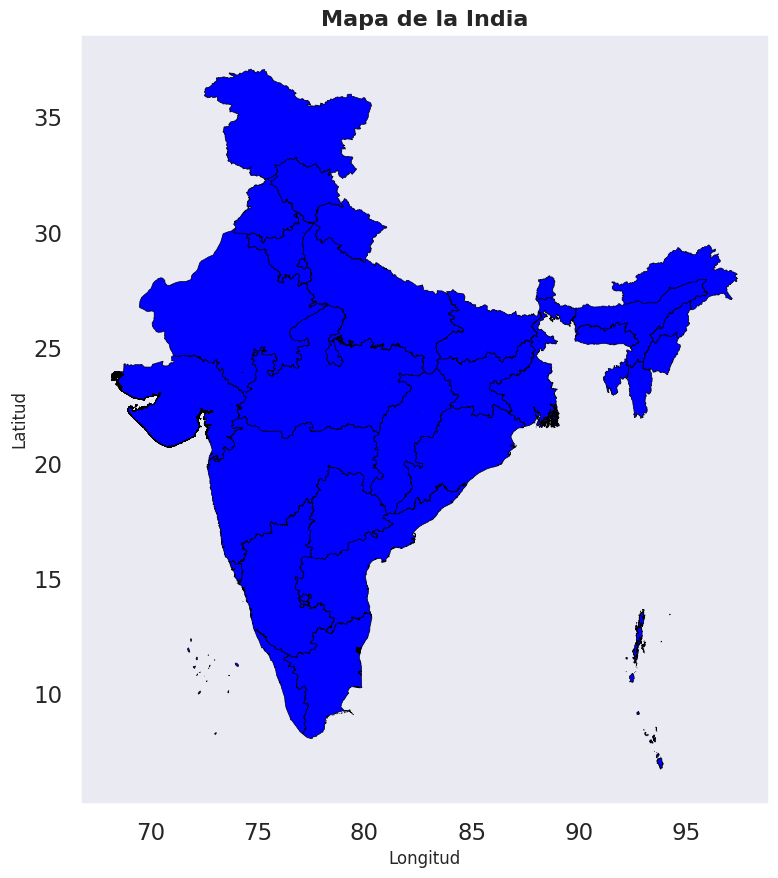

In [ ]:
# Configuración de estilo
sns.set_context('talk')
sns.set_style('dark')
color_unico = 'blue'

# Creción del gráfico
sizeFig = (15, 10)
fig, ax = plt.subplots(figsize=sizeFig)
dfMap.plot(color=color_unico, figsize=sizeFig,
           edgecolor='black', linewidth=0.5, ax=ax)

# Título y etiquetas
ax.set_title('Mapa de la India', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

plt.show()

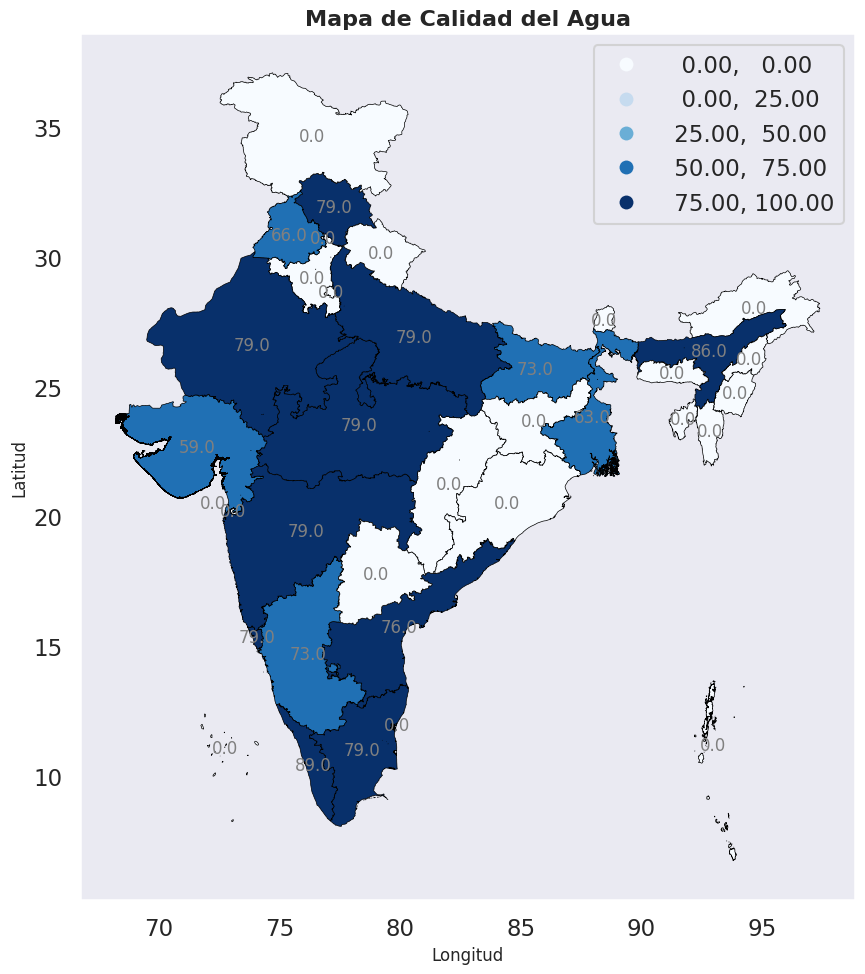

In [ ]:
# Reemplazar los valores NaN con 0
dfMap['WQI'] = dfMap['WQI'].fillna(0)

# Configuración de estilo y tamaño
sns.set_context('talk')
sns.set_style('dark')
cMap = 'Blues'
sizeFig = (10, 15)
bins = [0, 25, 50, 75, 100]

# Crear el gráfico
fig, ax = plt.subplots(figsize=sizeFig)
dfMap.plot(column='WQI', cmap=cMap, figsize=sizeFig,
           scheme='UserDefined', classification_kwds={'bins': bins},
           edgecolor='black', linewidth=0.5, legend=True, ax=ax)

# Añadir los valores del 'WQI'
for idx, fila in dfMap.iterrows():
    centroid = fila.geometry.centroid
    ax.text(centroid.x, centroid.y,
            size=12, s=fila['WQI'],
            color='grey', ha='center', va='center')

# Título y etiquetas
ax.set_title('Mapa de Calidad del Agua', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

plt.show()

## Observaciones sobre la Calidad del Agua por Estado

- Se puede observar que la mayoría de los estados presentan una calidad de agua superior al **70%** en el **Índice de Calidad del Agua (WQI)**. Sin embargo, aunque estos valores ya son preocupantes por sí mismos, indican que la calidad del agua aún podría mejorarse para cumplir con los estándares óptimos.
  
- Algunos estados tienen una calidad de agua inferior al **50%**, lo que sugiere la presencia de factores críticos como **niveles elevados de pH**, **contaminación por materia fecal** o **químicos**. Esto podría indicar una alta carga de contaminantes que necesita atención urgente.

- Los estados que tienen un valor de **0** en el WQI no tienen datos disponibles sobre la calidad del agua. Para evitar sesgos en el análisis, se decidió mantener estos valores en **0**, lo que indica que se desconoce la calidad del agua en esas regiones. Aunque otras alternativas, como reemplazar estos valores por la **media** o la **mediana** del conjunto de datos, podrían ser consideradas, hacerlo podría introducir sesgo debido a la presencia de **valores atípicos** (outliers). Dado que la cantidad de datos es limitada, es preferible no hacer estimaciones con poca certeza en estos casos.

---


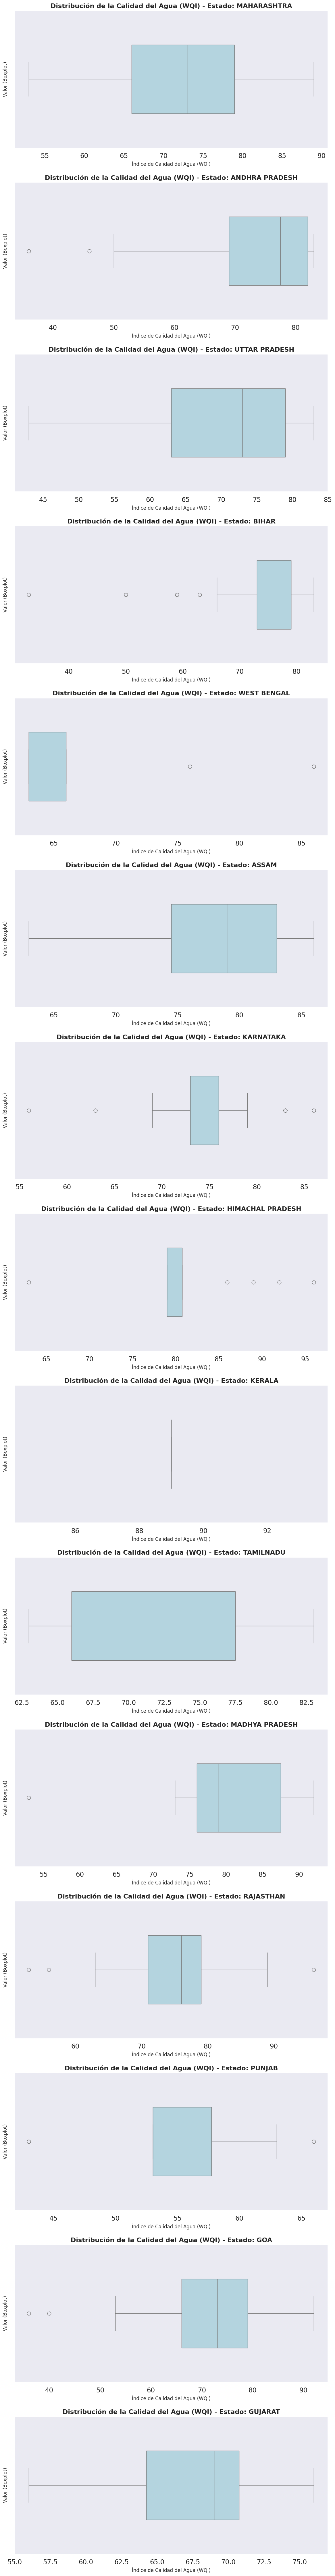

In [ ]:
# Cargar DataFrame
df05_pandas = df05.toPandas()

# Reemplazar valores NaN por 0
df05_pandas['WQI'] = df05_pandas['WQI'].fillna(0)

# Configuración de estilo y tamaño
sns.set_context('talk')
sns.set_style('dark')
fig, axes = plt.subplots(nrows=len(df05_pandas['STATE'].unique()), ncols=1, figsize=(12, len(df05_pandas['STATE'].unique()) * 6))


# Iterar sobre los estados y crear subgráficos
for idx, state in enumerate(df05_pandas['STATE'].unique()):
    ax = axes[idx]
    state_data = df05_pandas[df05_pandas['STATE'] == state]

    # Crear un gráfico de caja (boxplot) para WQI del estado
    sns.boxplot(x=state_data['WQI'], ax=ax, color='lightblue', width=0.5)

    # Configurar título y etiquetas
    ax.set_title(f'Distribución de la Calidad del Agua (WQI) - Estado: {state}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Índice de Calidad del Agua (WQI)', fontsize=12)
    ax.set_ylabel('Valor (Boxplot)', fontsize=12)
    ax2.set_ylabel('Frecuencia (Histograma)', fontsize=12)
    ax2.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Observaciones sobre la Distribución del WQI por Estado

- **Presencia de Outliers**: Muchos estados presentan *outliers* que dificultan la interpretación general de la calidad del agua. Estos valores extremos pueden influir negativamente en la capacidad de llegar a un consenso sobre el estado general del agua en cada región.

- **Distribución Variada por Estado**:
  - Algunos estados, como **Bihar**, muestran una distribución de calidad de agua que se aproxima al **70%**, lo que indica una calidad aceptable, aunque aún se podrían observar variaciones.
  - En contraste, **West Bengal** tiene una distribución de calidad de agua cercana al **65%**, lo que sugiere una calidad de agua algo más comprometida en comparación con otros estados.

- **Datos Nulos**: Es importante señalar que algunos estados, como **Kerala**, tienen datos faltantes o nulos, lo cual puede generar incertidumbre sobre la calidad del agua en esas regiones. Esto limita la capacidad de realizar una evaluación precisa.

- **Desafío para el Análisis General**: La variabilidad en las distribuciones de calidad del agua, combinada con la presencia de datos nulos y *outliers*, hace que sea complejo

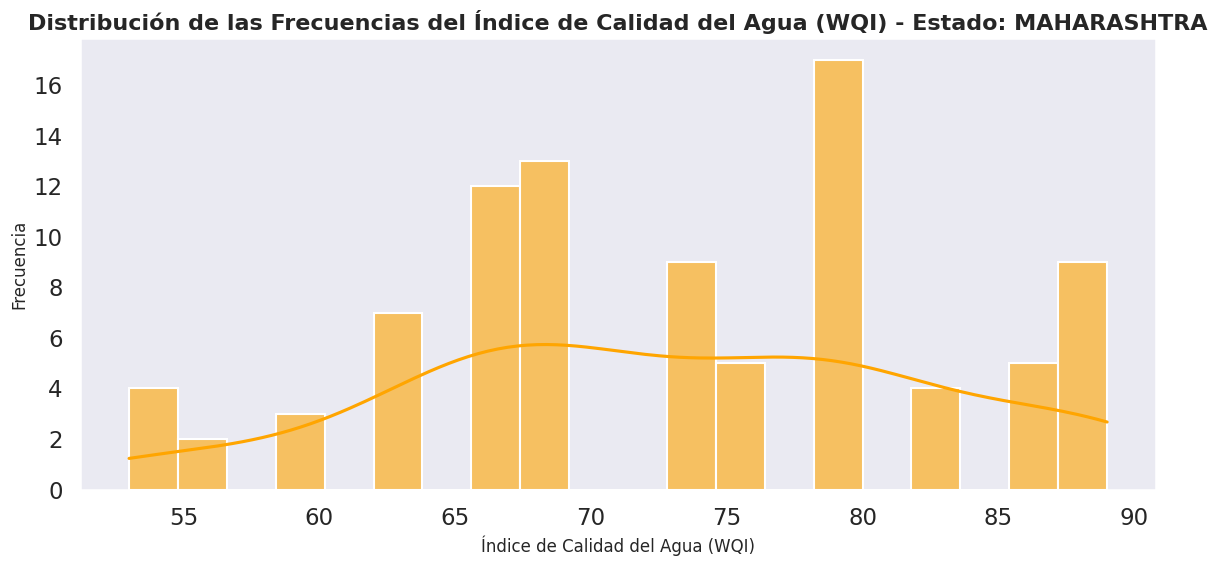

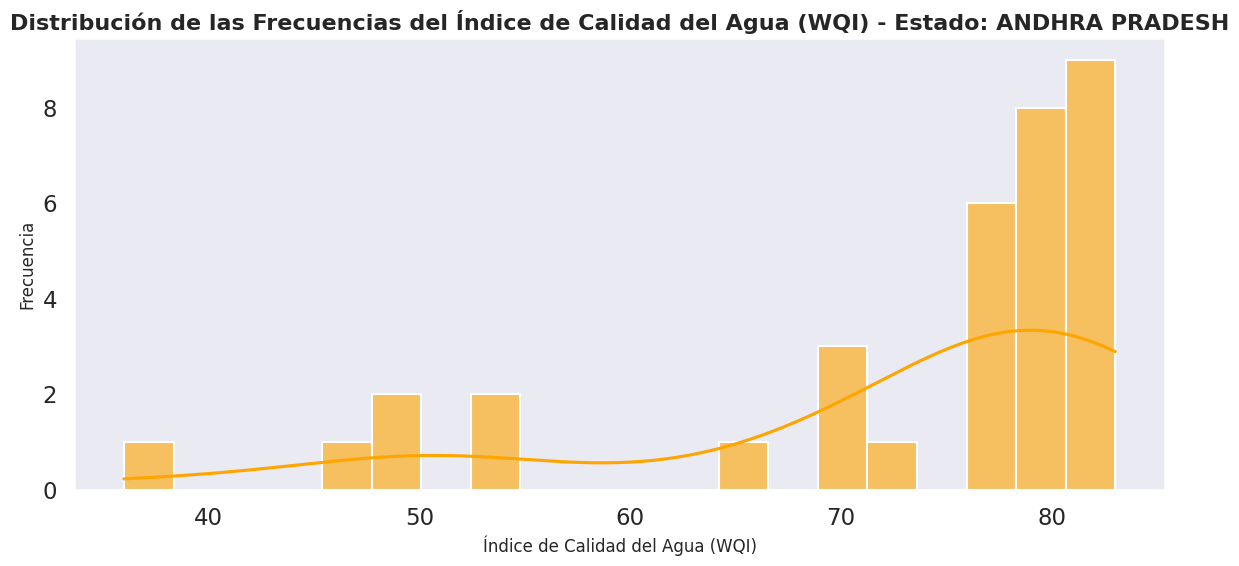

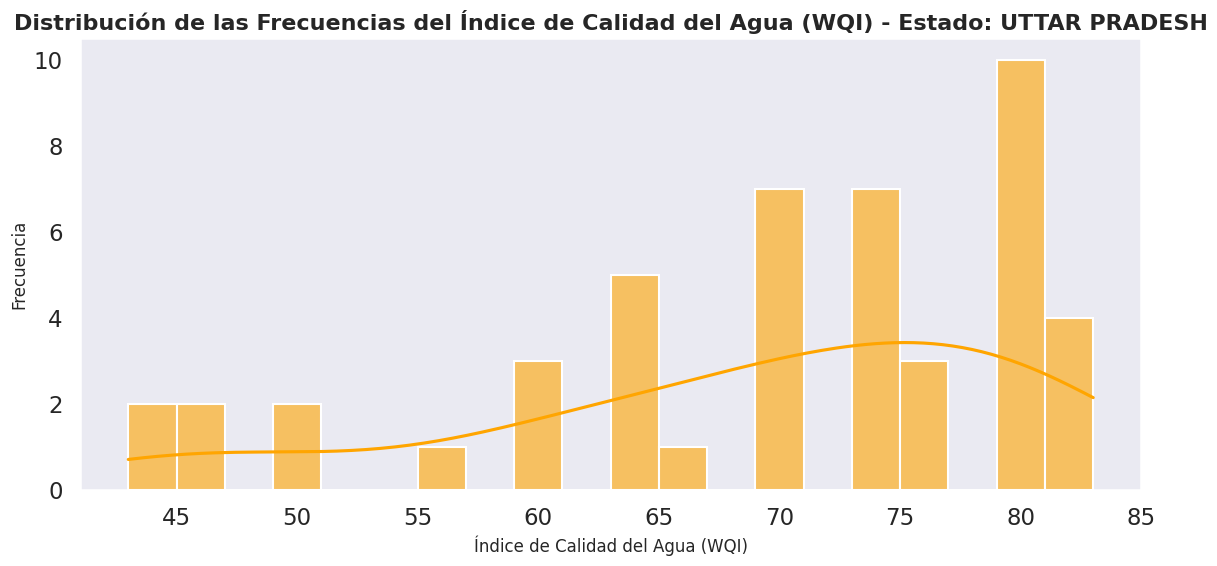

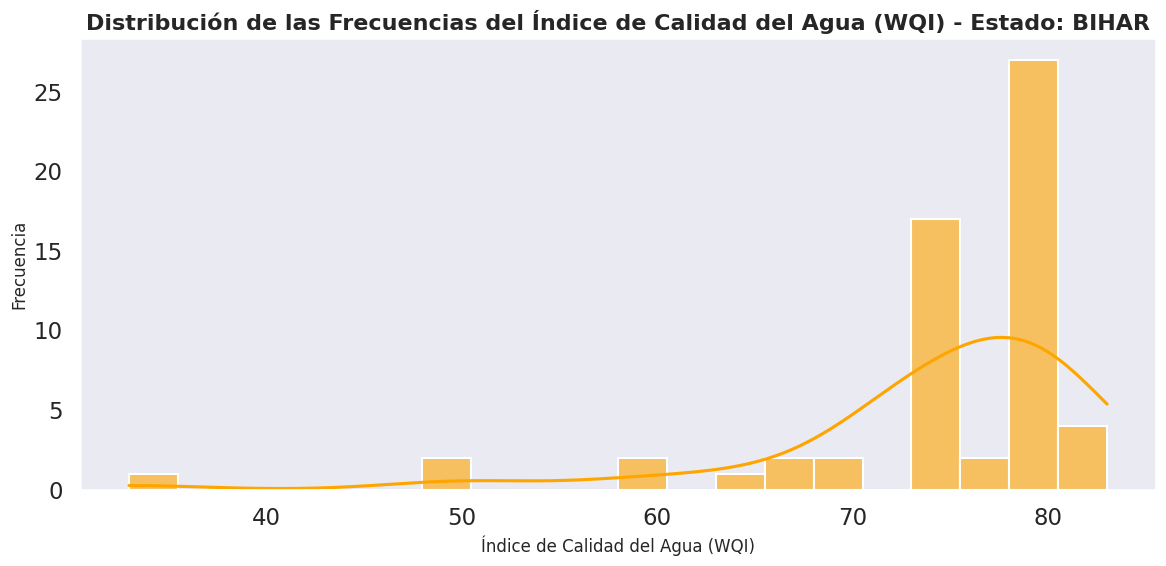

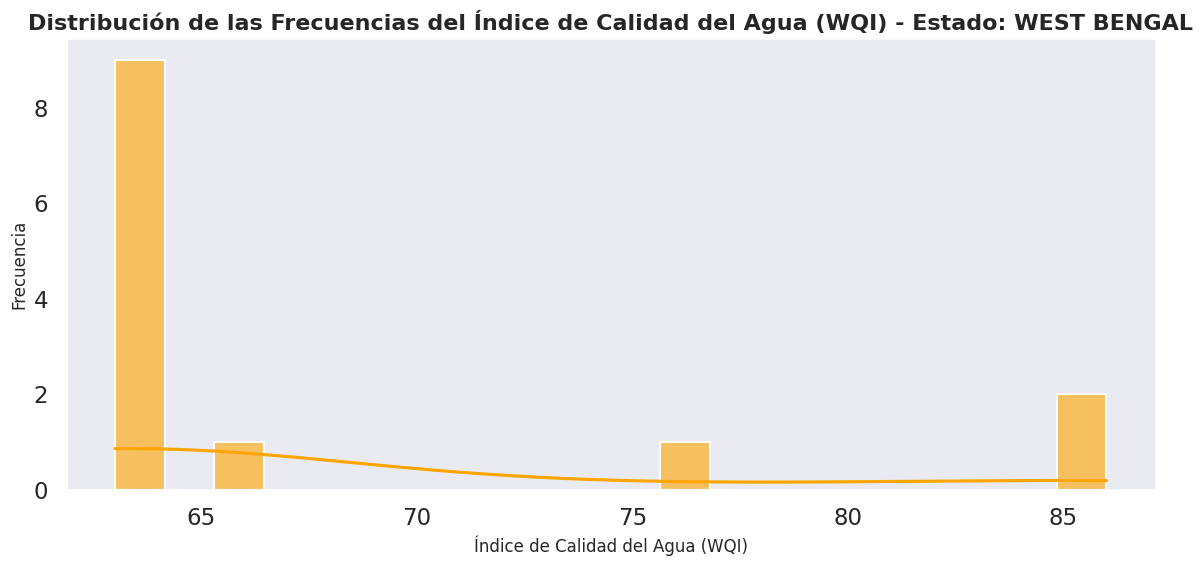

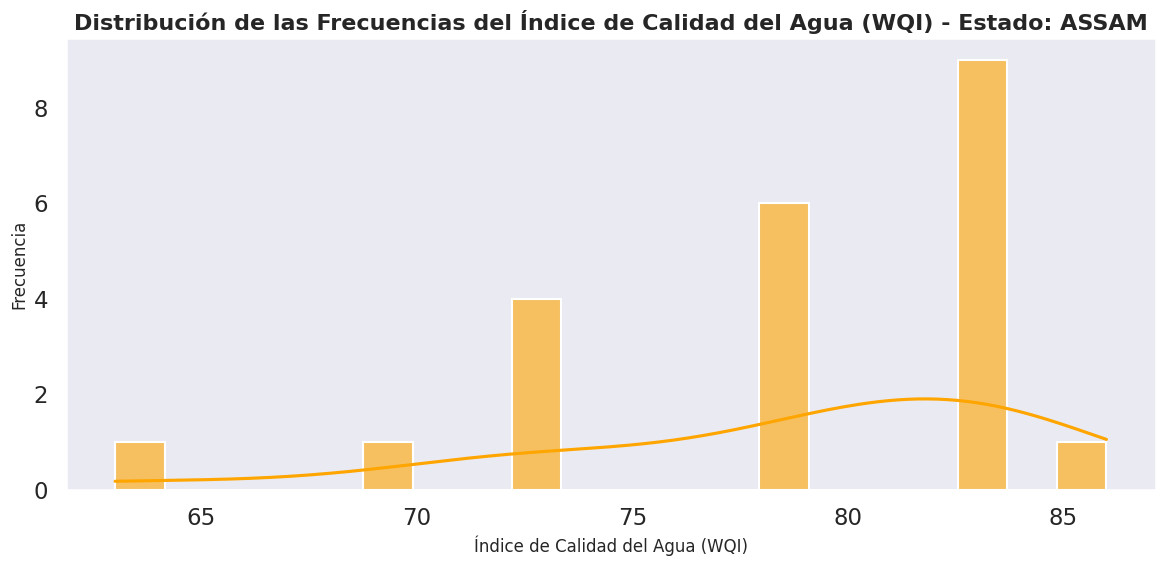

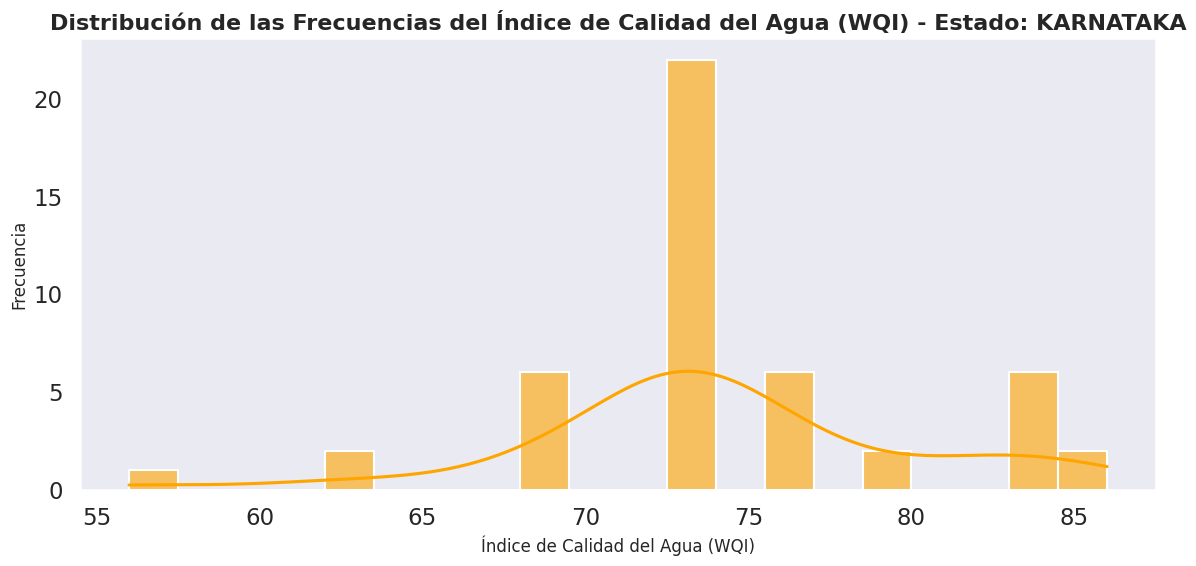

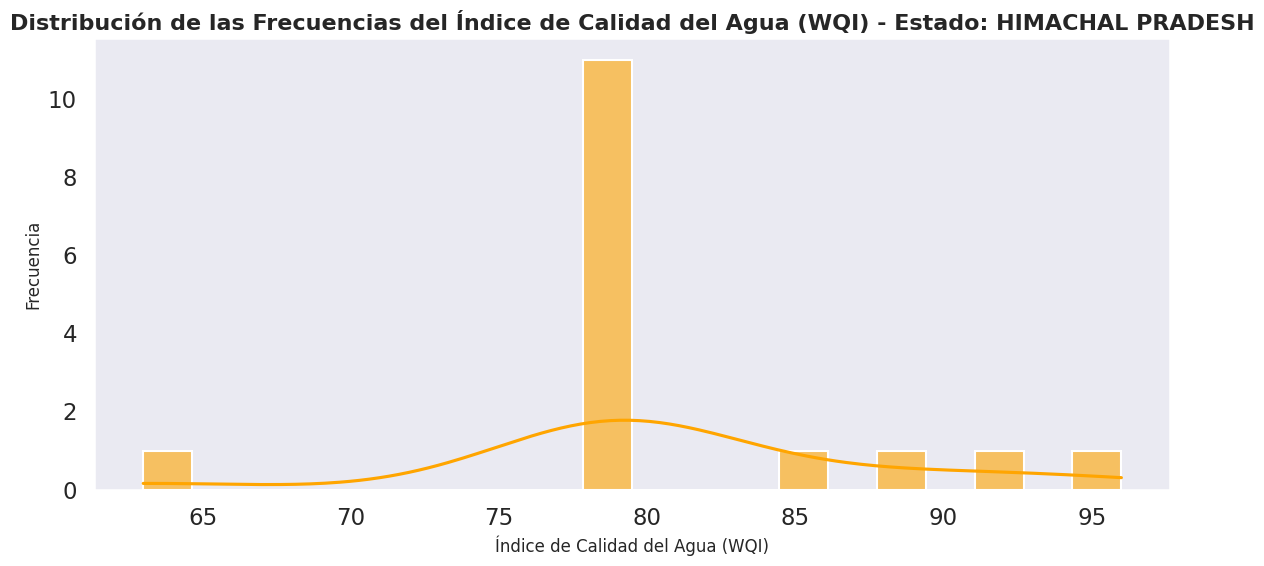

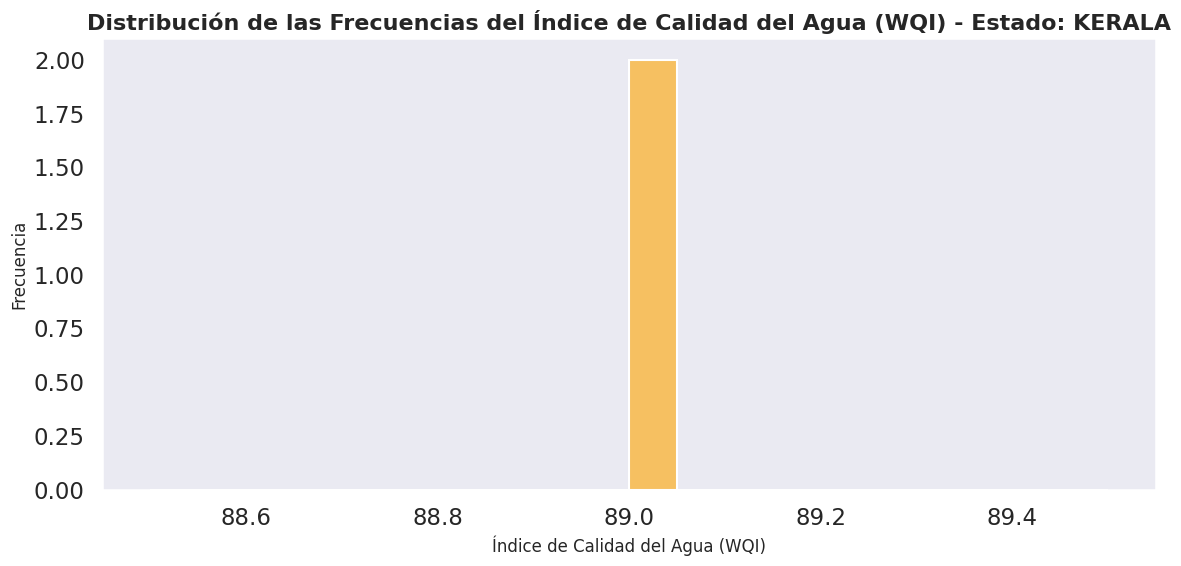

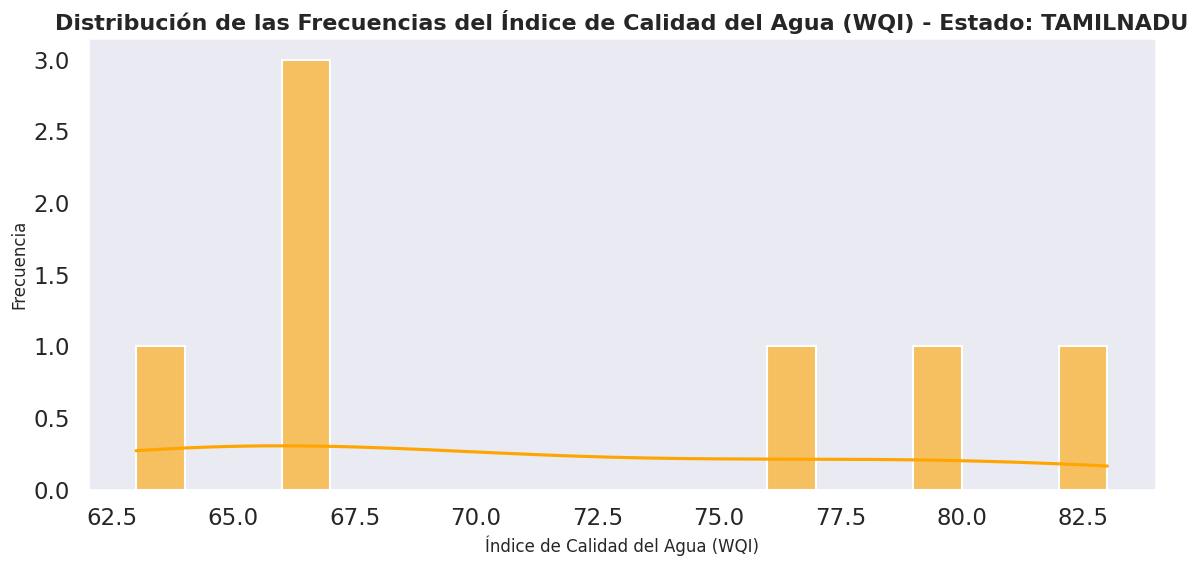

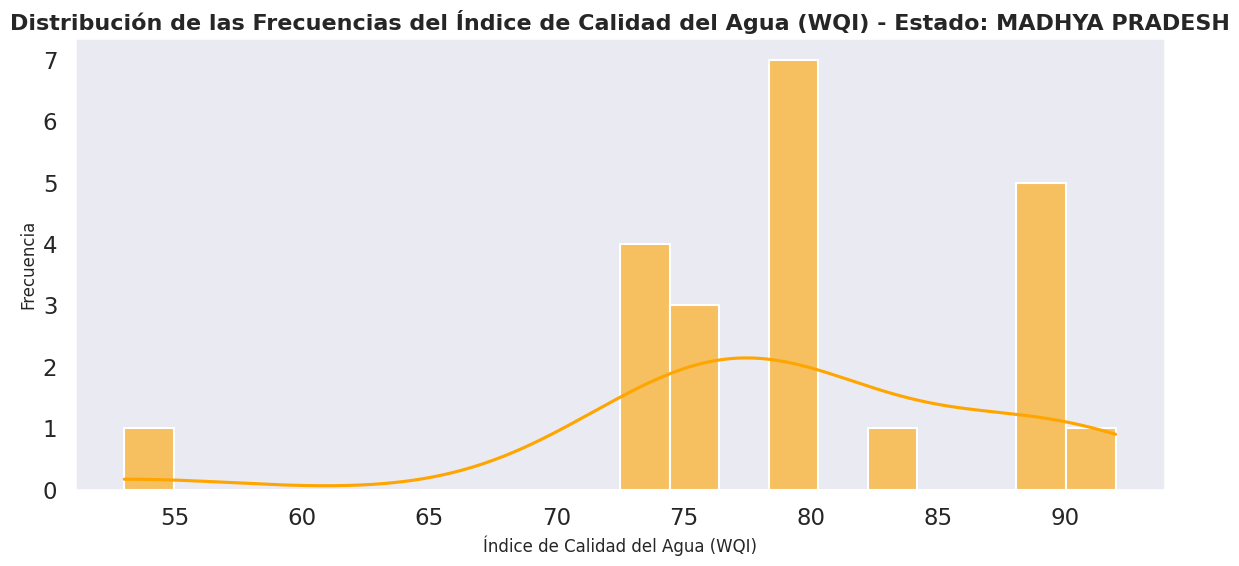

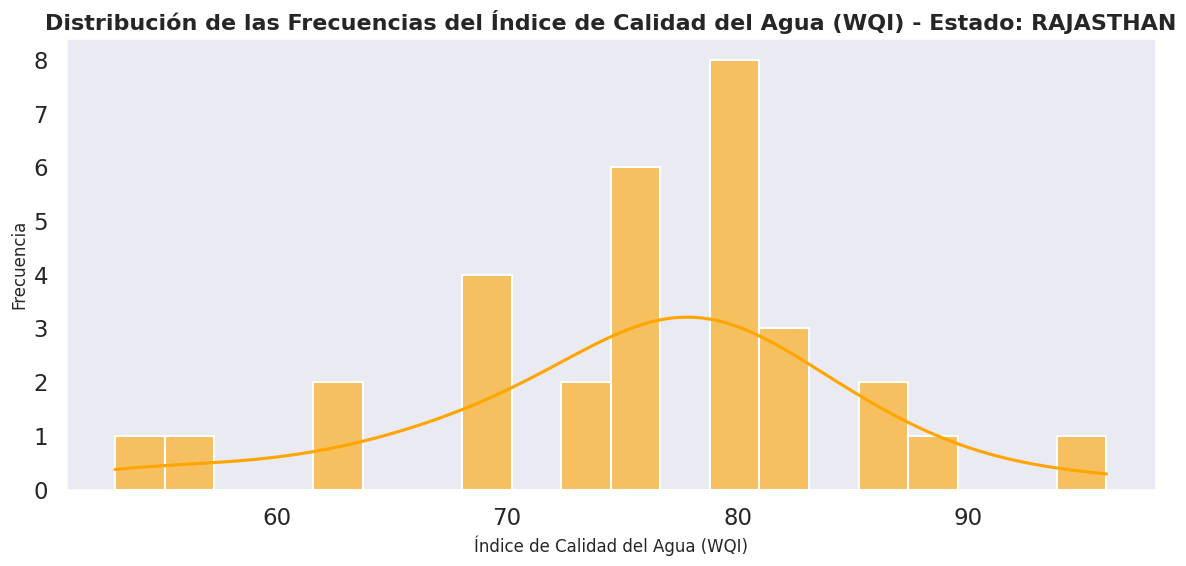

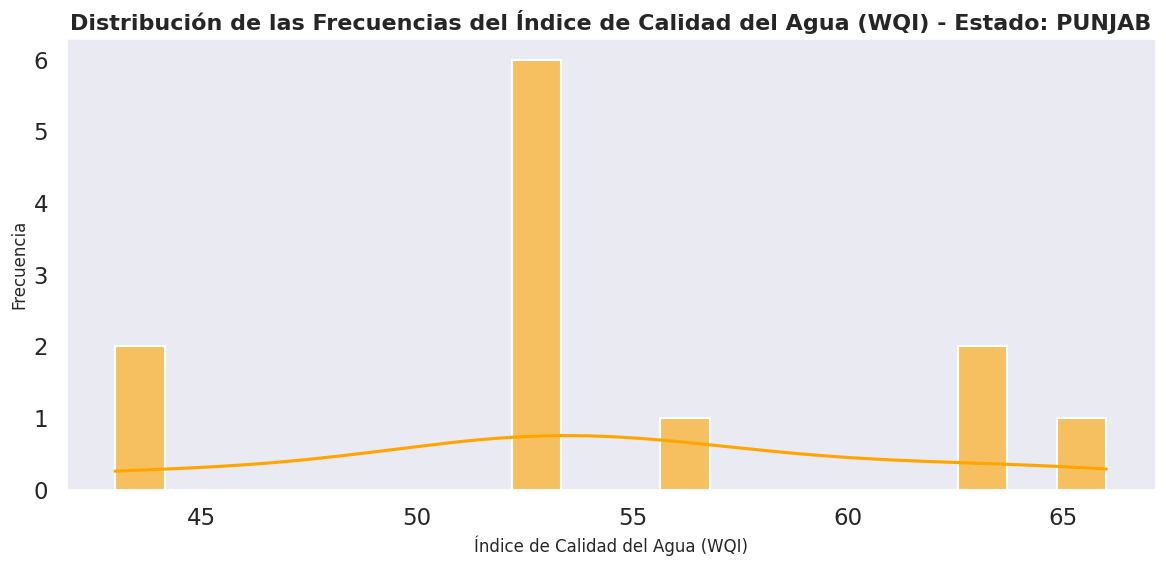

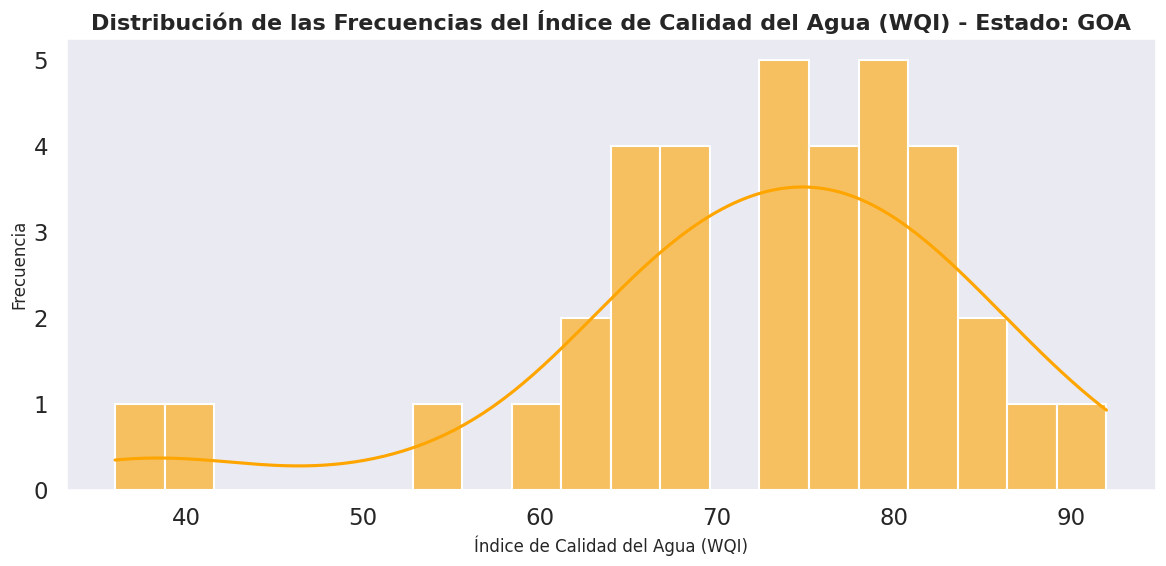

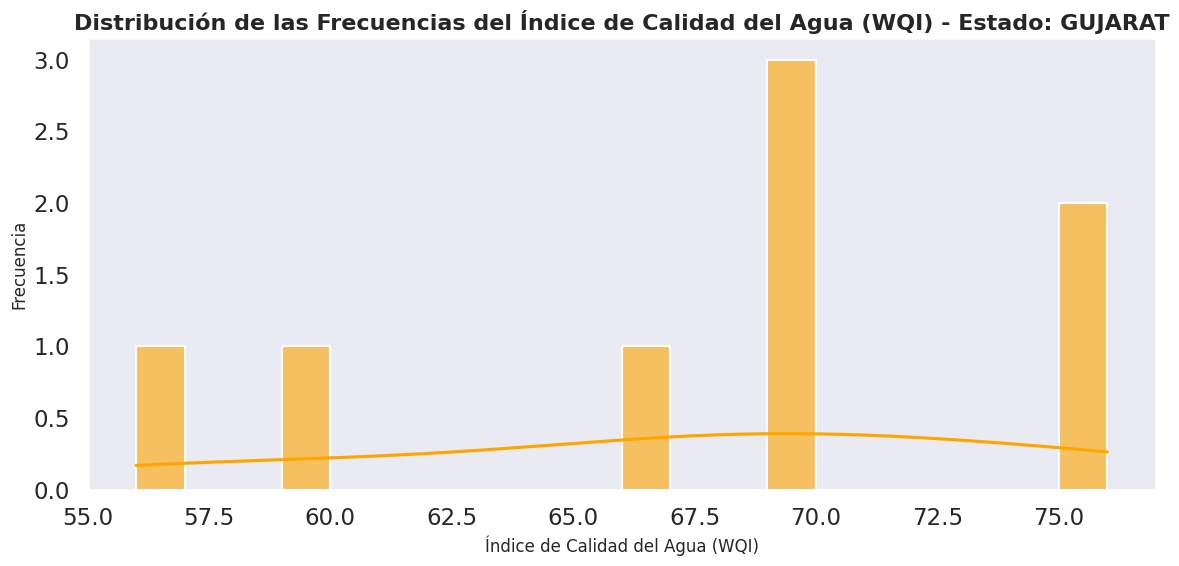

In [ ]:
# Configuración de estilo y tamaño
sns.set_context('talk')
sns.set_style('dark')

# Crear un gráfico separado para cada estado con su histograma de frecuencias
for state in df05_pandas['STATE'].unique():
    plt.figure(figsize=(12, 6))
    state_data = df05_pandas[df05_pandas['STATE'] == state]

    # Crear el histograma
    sns.histplot(state_data['WQI'], bins=20, kde=True, color='orange', alpha=0.6)

    # Añadir título y etiquetas
    plt.title(f'Distribución de las Frecuencias del Índice de Calidad del Agua (WQI) - Estado: {state}', fontsize=16, fontweight='bold')
    plt.xlabel('Índice de Calidad del Agua (WQI)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

## Observaciones sobre la Frecuencia del WQI por Estado

- **Datos Nulos**: Es importante señalar que algunos estados, como **Kerala**, tienen datos faltantes o nulos, lo cual puede generar incertidumbre sobre la calidad del agua en esas regiones. Esto limita la capacidad de realizar una evaluación precisa.

- **Desafío para el Análisis General**: La variabilidad en las distribuciones de calidad del agua, combinada con la presencia de datos nulos y *outliers*, hace que sea complejo
---

* Se requiere hacer una gráfica de WQI para cada STATE

In [ ]:
##Se convierte el DFpandas a Dataframe spark
pandasDF_spark = spark.createDataFrame(pandasDF)

#### Se crea una Tabla de Vista Temporal para hacer consultas SQL
pandasDF_spark.createOrReplaceTempView("dfMap_sql")

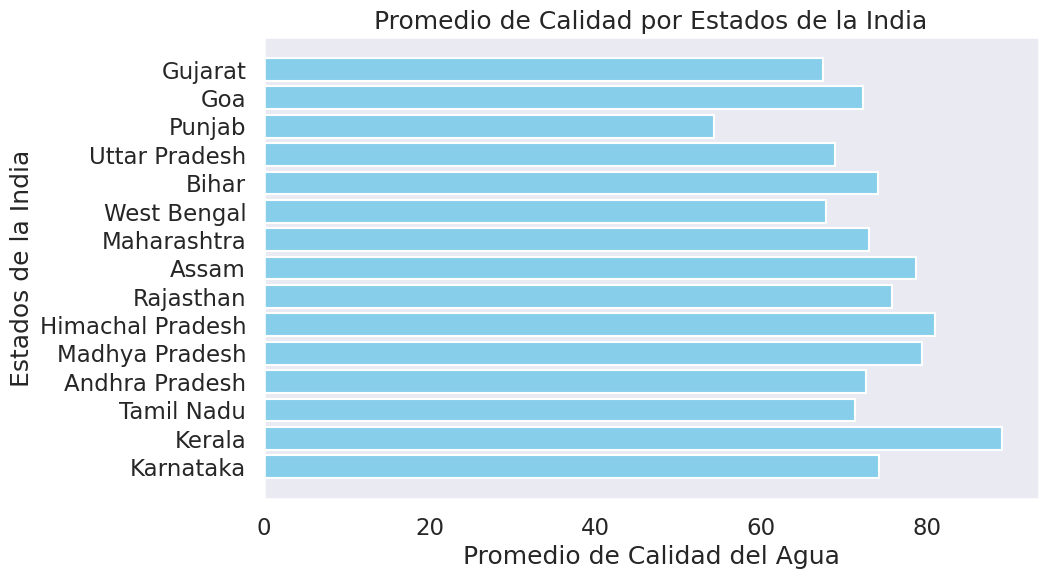

In [ ]:
# Agrupar por estado y calcular el promedio de WQI
val_WQI_estado = spark.sql("SELECT STATE, AVG(WQI) as avg_WQI FROM dfMap_sql GROUP BY STATE")

# Convertir el resultado a un formato adecuado para el gráfico
Estados = val_WQI_estado.rdd.map(lambda fila: fila.STATE).collect()
val_WQI_promedio = val_WQI_estado.rdd.map(lambda fila: fila.avg_WQI).collect()

# Graficar el histograma de WQI promedio por estado
plt.figure(figsize=(10, 6))
plt.barh(Estados, val_WQI_promedio, color='skyblue')
plt.xlabel('Promedio de Calidad del Agua')
plt.ylabel('Estados de la India')
plt.title('Promedio de Calidad por Estados de la India')
plt.show()

#**Creación de Modelo: Regresión Lineal**

* Se requiere predecir el valor WQI
* Se crea un vector ensamblador con las columnas **"Rangos de Calidad (qr)"**
* Se normalizan las columnas a través de Normalizer
* Se importa LinearRegression y se aplica los datos con el vector normalizado
* Se hace un "pipeline" para incluir el modelo
* Se separa los datos aleatoriamente (80%:entrenamiento, 20%:prueba)
* Se entrena el modelo con los datos de entrenamiento
* Se obtienen las predicciones con los datos de prueba y se muestran
* Se revisa el rendimiento del modelo con la métrica r2

## Matriz de Correlación

La **matriz de correlación** es una herramienta esencial para identificar las relaciones lineales, ya sean positivas o negativas, entre los parámetros del dataset y la variable objetivo, en este caso, el **Índice de Calidad del Agua (WQI)**. A continuación, se describe el proceso utilizado para calcular y analizar la matriz de correlación:

1. **Filtrado de Variables de Interés**:
   - Primero, se seleccionan las variables relevantes que se consideran significativas para el análisis y se crea un nuevo dataframe con esas variables.

2. **Cálculo de la Matriz de Correlación**:
   - Se calcula la matriz de correlación entre las variables seleccionadas para identificar las relaciones entre ellas y con el WQI.

3. **Gráfico y Análisis de la Matriz**:
   - Una vez calculada la matriz de correlación, se visualiza mediante un gráfico, lo que permite analizar de manera clara las correlaciones entre las variables y la variable objetivo.

In [ ]:
# Filtrar las columnas que contienen 'qr' o 'W'
filtered_columns = [col for col in pandasDF_spark.columns if 'qr' in col or 'W' in col]

# Crear un nuevo DataFrame con las columnas filtradas
train_data_filtered = pandasDF_spark[filtered_columns]

# Ver las columnas seleccionadas
print(train_data_filtered.head())

Row(qrPH=100, qrDO=100, qrCOND=0, qrBOD=80, qrNNN=100, qrFC=100, WQI=79.0)


In [ ]:
# Calcular la matriz de correlación usando una list comprehension y loop
correlation_matrix_filtered = pd.DataFrame([[train_data_filtered.select(F.corr(c1, c2)).first()[0]
                                           for c2 in filtered_columns]
                                          for c1 in filtered_columns],
                                         index=filtered_columns,
                                         columns=filtered_columns)

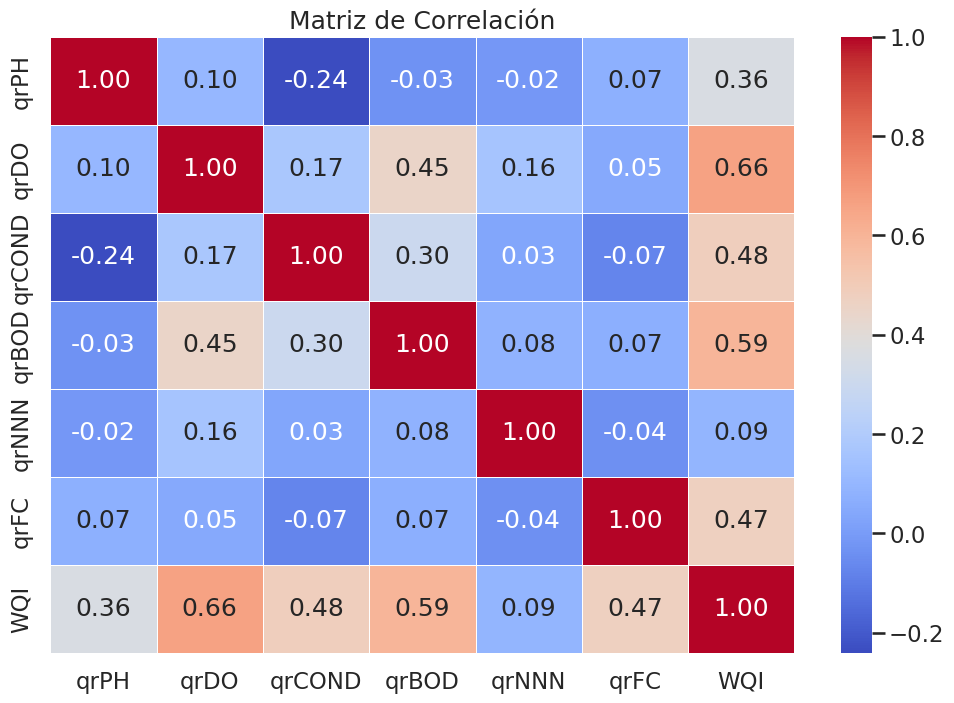

In [ ]:
# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
#Separación de datos aleatoriamente
train_data, test_data = pandasDF_spark.randomSplit([0.8, 0.2])

In [ ]:
# Importar los módulos necesarios
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# Se crea el VectorAssembler con la columna "features" como salida
vectorQR = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNNN', 'qrFC'], outputCol="features")

# Normalización
normalizerQR = Normalizer(inputCol="features", outputCol="feat_Normalizada")

# Se prepara el modelo de Regresión Lineal
Modelo_A_lineal = LinearRegression(featuresCol='feat_Normalizada', labelCol='WQI',
                                   maxIter=10, regParam=0.3, elasticNetParam=0.2)

# Se crea el pipeline con las etapas de procesamiento
pipe_A = Pipeline(stages=[vectorQR, normalizerQR, Modelo_A_lineal])

# Separación de los datos en conjunto de entrenamiento y prueba
train_data, test_data = pandasDF_spark.randomSplit([0.8, 0.2])

# Se entrena el modelo utilizando el conjunto de entrenamiento
LR_modelo = pipe_A.fit(train_data)

In [ ]:
#Se hacen las predicciones con los datos de entrenamiento
predicciones_train = LR_modelo.transform(train_data)

predicciones_train = predicciones_train.withColumn(
    "prediction",
    F.ceil(predicciones_train["prediction"] * 10) / 10
).withColumn(
    "WQI",
    F.ceil(predicciones_train["WQI"] * 10) / 10
)

# Mostrar las primeras 10 filas
predicciones_train.select("prediction", "WQI").show(10)

+----------+----+
|prediction| WQI|
+----------+----+
|      79.0|79.0|
|      27.7|36.0|
|      81.3|83.0|
|      78.7|79.0|
|      78.7|79.0|
|      64.7|63.0|
|      64.7|63.0|
|      64.7|63.0|
|      64.7|63.0|
|      64.7|63.0|
+----------+----+
only showing top 10 rows



In [ ]:
#Se hacen las predicciones con los datos de prueba
predicciones_test = LR_modelo.transform(test_data)
predicciones_train = predicciones_test.withColumn(
    "prediction",
    F.ceil(predicciones_test["prediction"] * 10) / 10
).withColumn(
    "WQI",
    F.ceil(predicciones_test["WQI"] * 10) / 10
)

# Mostrar las primeras 10 filas
predicciones_train.select("prediction", "WQI").show(10)

+----------+----+
|prediction| WQI|
+----------+----+
|      81.3|83.0|
|      78.8|79.0|
|      73.0|73.0|
|      70.0|69.0|
|      46.8|46.0|
|      46.8|46.0|
|      73.0|73.0|
|      76.0|76.0|
|      69.8|69.0|
|      84.1|86.0|
+----------+----+
only showing top 10 rows



In [ ]:
#Rendimiento del modelo con r2 como métrica
metricaR2 = LR_modelo.stages[-1].summary.r2
print("La métrica de rendimiento R2 para el Modelo Lineal es de: {:.2f}%".format(metricaR2 * 100))

La métrica de rendimiento R2 para el Modelo Lineal es de: 97.18%


#**Creación de Modelo: Aprendizaje Profundo (Deep Learning)**

* Se requiere predecir el valor WQI
* Se crea un DF en pandas, se crea los vectores numpy de columnas **"Rangos de Calidad (qr)"** y **WQI**
* Se importa Scikit-Learn, para separar los datos (20% para prueba)
* Se importa Keras Sequential con layers Dense
* Se inicializa el modelo, y se añaden las capas activador (RELU) y ultimo (lineal)
* Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio.
* Se realiza el entrenamiento

In [ ]:
#Se obtienen en vector numpy datos de los rangos de calidad de los parámetros (qrParametros)
datos = pandasDF.iloc[:, 10:16].values

#Se obtienen en vector numpy datos de valor a predecir "WQI"
prede = pandasDF.iloc[:, 22:23].values

In [ ]:
#Separación de datos con scikit-learn: train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos, prede, test_size=0.2, random_state=1)

In [ ]:
print(f'Cantidad de datos de Totales:{pandasDF.shape}')
print(f'Cantidad de datos de entrenamiento: {len(X_train)}')
print(f'Cantidad de datos de prueba: {len(X_test)}')
print(f'Cantidad de datos de entrenamiento: {len(y_train)}')
print(f'Cantidad de datos de prueba: {len(y_test)}')

Cantidad de datos de Totales:(447, 24)
Cantidad de datos de entrenamiento: 357
Cantidad de datos de prueba: 90
Cantidad de datos de entrenamiento: 357
Cantidad de datos de prueba: 90


In [ ]:
#Se importa instancia TensorFlow
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
#Se ajustan las variables
epocas = 200
lotes = 81

#Se inicializa el modelo con las capas: cantidad de dimensiones (6)
modelo_DL = Sequential()
modelo_DL.add(Dense(350, input_dim=6, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(350, activation='relu'))
modelo_DL.add(Dense(1, activation='linear'))

In [ ]:
##Se compila el modelo con el optimizador Adam y la función de pérdida error cuadrático medio
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
modelo_DL.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [ ]:
#Se presenta el resumen del modeloDL
modelo_DL.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 350)                 │           2,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 350)                 │         122,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 248,501 (970.71 KB)

 Trainable params: 248,501 (970.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
##Se entrena el modelo
rendi_Mod_DL = modelo_DL.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2275.6655 - mse: 2275.6655
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 105.0676 - mse: 105.0676
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 34.4588 - mse: 34.4588
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9103 - mse: 4.9103
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3735 - mse: 2.3735
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6156 - mse: 0.6156
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2727 - mse: 0.2727
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1414 - mse: 0.1414
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1229 - mse: 0.1229
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1088 - mse: 0.1088
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0928 - mse: 0.0928
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1111 - mse: 0.1111
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━

In [ ]:
#Se calcula la predicción
pred_DL_Train = modelo_DL.predict(X_train)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


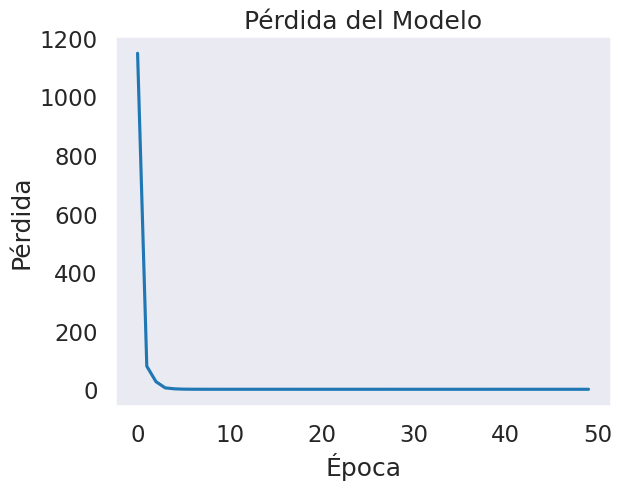

In [ ]:
#Se pinta la perdida: rendimiento del modelo
plt.plot(rendi_Mod_DL.history['loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()

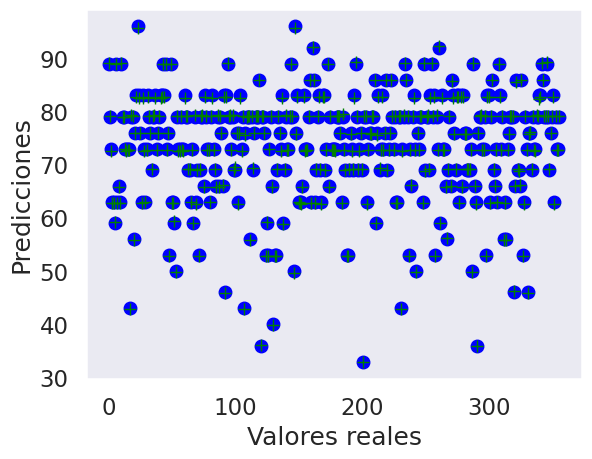

In [ ]:
#Se pinta las predicciones sobre datos conocidos (entrenamiento)
plt.plot(y_train, 'bo', pred_DL_Train, 'g+')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


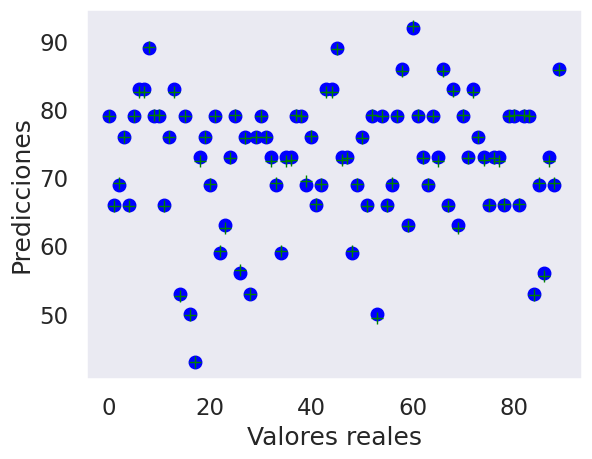

In [ ]:
#Se pinta las predicciones sobre datos desconodicos (prueba)
pred_DL_Test = modelo_DL.predict(X_test)
plt.plot(y_test, 'bo', pred_DL_Test, 'g+')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

#**Predicción de la Calidad del Agua**

* Hasta ahora se predice el Indice de Calida de Agua.
* Se requiere clasificar el agua según el WQI que se predice y así predecir su calidad.
* Se crea un modelo de Regresión Logística para predecir valores por categorias.
* La columna 'CALIDAD' contiene formato 'string', se convierte a 'StringIndexer'
* Se crea un vector assembler para los datos del índice
* Se normaliza los valores en el vector

In [ ]:
#Se convierte a spark dataframe
df_spark = spark.createDataFrame(pandasDF)

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression

In [ ]:
#Se crea el modelo de Regresión Logística
modelo_RL = LogisticRegression(featuresCol='features', labelCol='CALIDAD', maxIter=10)

#Se crea el pipeline para aplicar las configuraciones
pipe_RL = Pipeline(stages=[vectorQR, normalizerQR, modelo_RL])

In [ ]:
# Import StringIndexer to convert string to label index
from pyspark.ml.feature import StringIndexer

# Create StringIndexer to index the 'CALIDAD' column
indexer = StringIndexer(inputCol="CALIDAD", outputCol="labelIndex")

# Update your pipeline with the indexer
pipe_RL = Pipeline(stages=[indexer, vectorQR, normalizerQR, modelo_RL])

# Modify the Logistic Regression model to use the indexed label
modelo_RL = LogisticRegression(featuresCol='feat_Normalizada', labelCol='labelIndex', maxIter=10)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


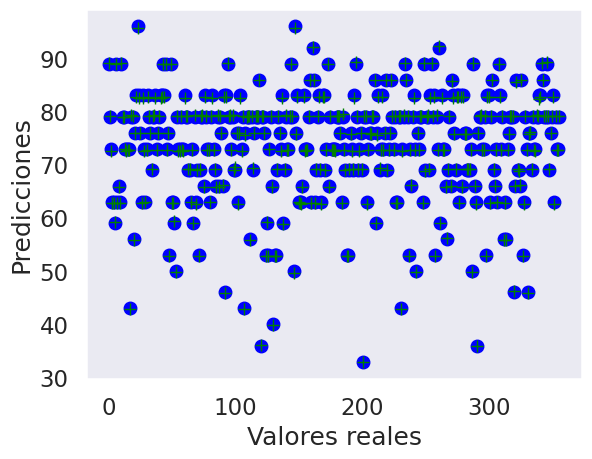

In [ ]:
#### Predicción sobre entrenamiento
pred_DL_Train = modelo_DL.predict(X_train)

### Se observan
plt.plot(y_train, 'bo', pred_DL_Train, 'g+')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


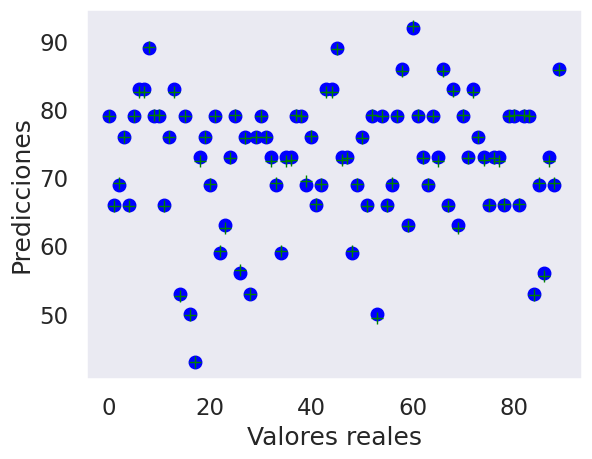

In [ ]:
#### Predicción sobre prueba
pred_DL_Test = modelo_DL.predict(X_test)

### Se observan
plt.plot(y_test, 'bo', pred_DL_Test, 'g+')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()

* Se revisa el rendimiento (métrica) del modelo RL

In [ ]:
# Import StringIndexer to convert string to label index
from pyspark.ml.feature import StringIndexer

# Create StringIndexer to index the 'CALIDAD' column
indexer = StringIndexer(inputCol="CALIDAD", outputCol="labelIndex")

# Import necessary modules for VectorAssembler and Normalizer
from pyspark.ml.feature import VectorAssembler, Normalizer

# Create VectorAssembler to create the features column
vectorQR = VectorAssembler(inputCols=['qrPH', 'qrDO', 'qrCOND', 'qrBOD', 'qrNNN', 'qrFC'], outputCol="features")

# Normalize the features column
normalizerQR = Normalizer(inputCol="features", outputCol="feat_Normalizada")

# Import the Logistic Regression model
from pyspark.ml.classification import LogisticRegression

# Create Logistic Regression model with the labelIndex column
modelo_RL = LogisticRegression(featuresCol='feat_Normalizada', labelCol='labelIndex', maxIter=10)

# Import the Pipeline module
from pyspark.ml import Pipeline

# Create pipeline with all stages
pipe_RL = Pipeline(stages=[indexer, vectorQR, normalizerQR, modelo_RL])

# Fit the pipeline with train data
modelo_entrenado = pipe_RL.fit(train_data)

# Make predictions with test data
predicciones_test = modelo_entrenado.transform(test_data)

# Import the MulticlassClassificationEvaluator module
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create evaluator with the labelIndex and prediction columns
metricaRL = MulticlassClassificationEvaluator(labelCol='labelIndex', predictionCol='prediction', metricName='accuracy')

# Calculate and print the accuracy metric
accuracy = metricaRL.evaluate(predicciones_test)
print("La métrica de rendimiento del Modelo RL es de: {:.2f}%".format(accuracy * 100))

La métrica de rendimiento del Modelo RL es de: 96.59%


* Como la columna "CALIDAD" esta en formato string (categorias), se convierten los valores que predicen a formato string y así compararlos en categorias.

In [ ]:
##Se obtienen las categorias
categorias = predicciones_test.select('CALIDAD').distinct().collect()

In [ ]:
categoria = ['Muy_Baja', 'Baja', 'Inadecuada', 'Excelente']

In [ ]:
#Se crea una tabla temporal
predicciones_test.createOrReplaceTempView("predicciones_test_sql")

# se visualiza la tabla temporal
spark.sql("SELECT * FROM predicciones_test_sql").show(10)

+------------+--------------------+--------------+------------------+-----------------+-----------------+------------+------------------+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|STATION CODE|           LOCATIONS|         STATE|              TEMP|               DO|               pH|CONDUCTIVITY|               BOD|NITRATE_N_NITRITE_N|FECAL_COLIFORM|qrPH|qrDO|qrCOND|qrBOD|qrNNN|qrFC| wPH| wDO|wCOND|wBOD|wNNN| wFC| WQI|   CALIDAD|labelIndex|            features|    feat_Normalizada|       rawPrediction|         probability|prediction|
+------------+--------------------+--------------+------------------+-----------------+-----------------+------------+------------------+-------------------+--------------+----+----+------+-----+-----+----+----+----+-----+----+----+----+----+----------+----------+----------------

In [ ]:
#Se presentan las primeras 20 predicciones del entrenamiento
spark.sql("SELECT prediction, CALIDAD FROM predicciones_test_sql").show(20)

+----------+----------+
|prediction|   CALIDAD|
+----------+----------+
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       1.0|      Baja|
|       1.0|      Baja|
|       1.0|Inadecuada|
|       1.0|Inadecuada|
|       1.0|      Baja|
|       0.0|  Muy_Baja|
|       1.0|      Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       1.0|      Baja|
|       0.0|  Muy_Baja|
|       1.0|      Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
|       0.0|  Muy_Baja|
+----------+----------+
only showing top 20 rows



In [ ]:
### Se usa f1 score como metrica del modelo
f1_score = metricaRL.evaluate(predicciones_test, {metricaRL.metricName: 'f1'})
print("La métrica de rendimiento del Modelo RL es de: {:.2f}%".format(f1_score * 100))

La métrica de rendimiento del Modelo RL es de: 96.37%


# Conclusiones Generales

A partir de los análisis realizados y los resultados obtenidos, se pueden extraer las siguientes conclusiones:

- **Alta Correlación de Variables**:
  - Los modelos de **regresión lineal**, **redes neuronales** y **vector assembler** lograron un rendimiento superior al 90% en los datos de prueba. Esto indica una alta correlación entre las variables del conjunto de datos, lo que sugiere que los parámetros como la temperatura, el pH, la conductividad y la materia fecal tienen un impacto significativo en el **Índice de Calidad del Agua (WQI)**.

- **Distribución y Calidad del Agua**:
  - Se observó que muchos estados presentan **outliers** que dificultan llegar a un consenso general sobre la calidad del agua. Por ejemplo, algunos estados como **BIHAR** tienen una distribución de calidad del agua superior al 70%, mientras que otros como **WEST BENGAL** presentan valores cercanos al 65%. Algunos estados, como **KERALA**, carecen de datos, lo que resalta la importancia de mejorar la cobertura de datos para obtener una visión más completa.

- **Implicaciones para el Gobierno y el Ministerio de Salud**:
  - Estos resultados son cruciales para la **gestión del agua** y la **salud pública**, ya que indican áreas que podrían requerir **intervenciones regulatorias** o **acciones correctivas**. La alta correlación entre los parámetros de calidad del agua y el WQI permite identificar qué factores tienen un impacto más directo sobre la salud pública, como la **materia fecal** o la **conductividad**.
  - Para **gobiernos** y **ministerios de salud**, esta información es invaluable, ya que facilita la **toma de decisiones informadas** sobre políticas públicas y estrategias para mejorar la calidad del agua. Con estos modelos, se puede predecir la calidad del agua en diversas regiones, lo que permite tomar acciones proactivas para **evitar enfermedades** relacionadas con la calidad del agua.
  - Además, una **mejor gestión de los recursos hídricos** basada en datos puede mejorar la distribución equitativa del agua, **reducir la contaminación** y **prevenir brotes de enfermedades** transmitidas por el agua. Los resultados podrían llevar a la implementación de tecnologías avanzadas de monitoreo de la calidad del agua, ayudando a mejorar la infraestructura sanitaria.

# **Referencias**

* **[1]** Spellman FR. Handbook of Water and Wastewater Treatment Plant Operations. 3rd ed. Boca Raton: CRC Press; 2013.
* **[2]** Summer Kevin. [Water Quality](https://www.intechopen.com/chapters/69568). IntechOpen; DOI 978-1-78985-578-4.2020.
* **[3]** Hammer MJ. Water and Wastewater Technology. 7th ed. Upper Saddle River: Pearson education; 2011.
* **[4]** Tchobanoglous G, Burton FL, Stensel HD. Metcalf & Eddy Wastewater Engineering: Treatment and Reuse. 4th ed. New Delhi: Tata McGraw-Hill Limited; 2003.
* **[5]** Alley ER. Water Quality Control Handbook. Vol. 2. New York: McGraw-Hill; 2007.

* **[6]** Nathanson JA. Basic Environmental Technology: Water Supply. New Delhi: Printice-Hall of India; 2004

